# <center>Impacto de Fatores de Risco em Casos Confirmados de Covid-19 no Estado de São Paulo</center>
###    <center>Um Estudo com Regras de Associação e Algoritmos para Classificação de Óbitos</center>

In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
%matplotlib inline

In [3]:
import datetime 
from datetime import timedelta

In [4]:
from unidecode import unidecode
import json

In [5]:
#geral para todos os algoritmos
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
import cf_matrix as cfm # Módulo disponível em https://github.com/DTrimarchi10/confusion_matrix

#função utilizando o módulo que será usada para visualizar a matrix de confusão para todos os modelos
def make_confusion_matrix(cf_matrix):
    labels = ['True Neg','False Pos','False Neg','True Pos']
    categories = ['Zero', 'One']
    cfm.make_confusion_matrix(cf_matrix, 
                          group_names=labels,
                          categories=categories, 
                          cmap='binary')

In [6]:
#Regressao Logistica
from sklearn.linear_model import LogisticRegression

In [7]:
#Arvores de Decisao
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree

In [8]:
#Florestas Aleatórias
from sklearn.ensemble import RandomForestClassifier

In [9]:
#Classificação Bayesiana
from sklearn.naive_bayes import CategoricalNB

In [10]:
#Regras de Associação
from mlxtend.frequent_patterns import apriori 
from mlxtend.frequent_patterns import association_rules

# Tratamento e Processamento de Dados

In [11]:
arquivo = '20210819_Casos-e-obitos-ESP.csv' #baixado em 20/08

In [12]:
idade_referencia = 60 # Segundo o Ministério da Saúde 
# https://www.gov.br/saude/pt-br/coronavirus/atendimento-tratamento-e-fatores-de-risco

In [13]:
df = pd.read_csv(arquivo, sep = ';') 

In [14]:
tam = len(df)
tam

4195466

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4195466 entries, 0 to 4195465
Data columns (total 19 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   Genero                   object 
 1   Municipio                object 
 2   Asma                     object 
 3   Diabetes                 object 
 4   Cardiopatia              object 
 5   Doenca Hematologica      object 
 6   Doenca Hepatica          object 
 7   Doenca Neurologica       object 
 8   Doenca Renal             object 
 9   Imunodepressao           object 
 10  Obesidade                object 
 11  Pneumopatia              object 
 12  Puérpera                 object 
 13  Síndrome De Down         object 
 14  Outros Fatores De Risco  object 
 15  Diagnostico Covid19      object 
 16  Data Inicio Sintomas     object 
 17  Idade                    float64
 18  Obito                    int64  
dtypes: float64(1), int64(1), object(17)
memory usage: 608.2+ MB


In [16]:
nulos = df.isnull().sum()
nulos

Genero                         1
Municipio                      0
Asma                           0
Diabetes                       0
Cardiopatia                    0
Doenca Hematologica            0
Doenca Hepatica                0
Doenca Neurologica             0
Doenca Renal                   0
Imunodepressao                 0
Obesidade                      0
Pneumopatia                    0
Puérpera                       0
Síndrome De Down               0
Outros Fatores De Risco        0
Diagnostico Covid19            0
Data Inicio Sintomas       37252
Idade                      11757
Obito                          0
dtype: int64

In [17]:
print('Porcentagem de dados nulos na coluna Genero: {0:.2f}%'.format(nulos[0]/tam*100))

Porcentagem de dados nulos na coluna Genero: 0.00%


In [18]:
print('Porcentagem de dados nulos na coluna Genero: {0:.2f}%'.format(nulos[16]/tam*100))

Porcentagem de dados nulos na coluna Genero: 0.89%


In [19]:
print('Porcentagem de dados nulos na coluna Genero: {0:.2f}%'.format(nulos[17]/tam*100))

Porcentagem de dados nulos na coluna Genero: 0.28%


Dada a baixíssima porcentagem de dados nulos, optou-se por excluí-los do dataframe

In [20]:
#Exclusão dos valores nulos
df.dropna(inplace=True)

In [21]:
nulos = df.isnull().sum()
nulos

Genero                     0
Municipio                  0
Asma                       0
Diabetes                   0
Cardiopatia                0
Doenca Hematologica        0
Doenca Hepatica            0
Doenca Neurologica         0
Doenca Renal               0
Imunodepressao             0
Obesidade                  0
Pneumopatia                0
Puérpera                   0
Síndrome De Down           0
Outros Fatores De Risco    0
Diagnostico Covid19        0
Data Inicio Sintomas       0
Idade                      0
Obito                      0
dtype: int64

Quantidade de dados antes da exclusão:

In [22]:
tam

4195466

Quantidade de dados após a exclusão dos nulos:

In [23]:
len(df)

4153269

Porcentagem dos dados originais que foi excluída devido aos nulos:

In [24]:
'{:.2f}%'.format((1-(len(df)/tam)) * 100)

'1.01%'

Sobre os dados disponibilizados pelo estado de São Paulo, não se pode dizer se os últimos registros são sobre pessoas que se recuperam ou chegam a óbito, pois esses registros não tiveram tempo o suficiente para recebe essa atualização. Sendo assim, optou-se por remover do dataframe os últimos registros informados, para que não confundam o algoritmo com informações falsas.
Como converter a coluna para um tipo de data foi muito custoso para o processamento, foi escolhida a estratégia de aplicar uma função sobre a coluna que analisa a data para saber se está no período válido.

In [25]:
#REMOVER OS DADOS DOS ÚLTIMOS DIAS REGISTRADOS, 
#POIS NÃO SE PODE AFIRMAR QUE TODOS QUE SÃO 0 REALMENTE SE RECUPERARAM

In [26]:
ultima_atualizacao_dados = datetime.datetime(int(arquivo[:4]), int(arquivo[4:6]), int(arquivo[6:8]))
print(ultima_atualizacao_dados)

2021-08-19 00:00:00


In [27]:
def dentro_do_periodo(data_inicio_sintomas):
    dia = data_inicio_sintomas[:2]
    mes = data_inicio_sintomas[3:5]
    ano = data_inicio_sintomas[6:]
    data_inicio_sintomas = datetime.datetime(int(ano), int(mes), int(dia)) 
    if data_inicio_sintomas < (ultima_atualizacao_dados - timedelta(days=20)):
        return True
    else: 
        return False

In [28]:
df['periodo_valido'] = df['Data Inicio Sintomas'].apply(dentro_do_periodo)

In [29]:
#Resultado da verificação de período

In [30]:
df['periodo_valido'].value_counts(normalize=True)

True     0.987261
False    0.012739
Name: periodo_valido, dtype: float64

In [31]:
df['periodo_valido'].value_counts()

True     4100360
False      52909
Name: periodo_valido, dtype: int64

In [32]:
#Exclusão dos dados fora do período válido
df.drop(df[df['periodo_valido'] == False].index, inplace=True)

In [33]:
df['periodo_valido'].value_counts()

True    4100360
Name: periodo_valido, dtype: int64

In [34]:
#Exclusão da coluna, pois não será mais útil
df.drop('periodo_valido', axis=1, inplace=True)

Pode ser observado que todos os registros são referentes a casos confirmados de Covid-19:

In [35]:
df['Diagnostico Covid19'].value_counts()

CONFIRMADO    4100360
Name: Diagnostico Covid19, dtype: int64

In [36]:
#Verificando a quantidade e porcentagem geral dos óbitos

In [37]:
df['Obito'].value_counts(normalize=True)

0    0.965052
1    0.034948
Name: Obito, dtype: float64

In [38]:
df['Obito'].value_counts()

0    3957062
1     143298
Name: Obito, dtype: int64

(-1.106079854703421,
 1.1078760336277267,
 -1.1082549055017943,
 1.100393097919232)

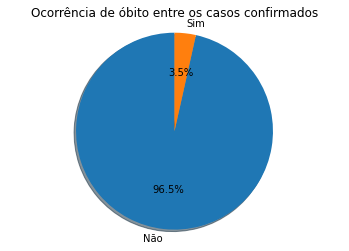

In [39]:
labels = 'Não', 'Sim'
sizes = df['Obito'].value_counts()

fig1, ax1 = plt.subplots()
plt.title('Ocorrência de óbito entre os casos confirmados')
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')

## Idade

Distribuição de idade entre os casos de covid.
Note que a distribuição da idade entre os casos recuperados se parece muito com a distribuição geral, enquanto a distribuição das idades nos casos que chegaram a óbito já é diferente.

<AxesSubplot:>

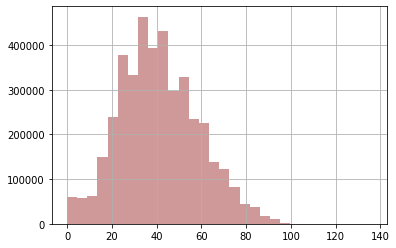

In [40]:
#Distribuição geral
df['Idade'].hist(bins=30, color='darkred', alpha=0.4)

<AxesSubplot:>

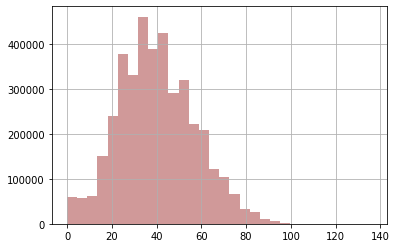

In [41]:
#Distribuição de idade entre os casos recuperados
df[df['Obito']==0]['Idade'].hist(bins=30, color='darkred', alpha=0.4)

<AxesSubplot:>

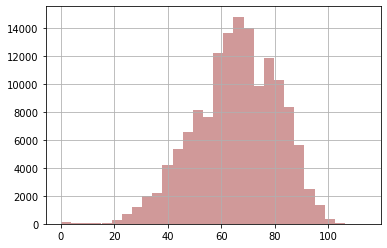

In [42]:
#Distribuição de idade entre os casos de óbito
df[df['Obito']==1]['Idade'].hist(bins=30, color='darkred', alpha=0.4)

Se as idades mínimas e máximas forem observadas entre os registros, percebe-se a ocorrência de dados ruidosos. É possível que a idade 0 seja a ausência da informação, enquanto idades muito altas entre os dados é podem ser erros de cadastro. O gráfico do tipo boxplot vai evidenciar os outliers a serem removidos para que a informação seja tratada.

In [43]:
df['Idade'].mean()

41.031705021022546

In [44]:
df['Idade'].min()

0.0

In [45]:
df['Idade'].max()

136.0

<AxesSubplot:ylabel='Idade'>

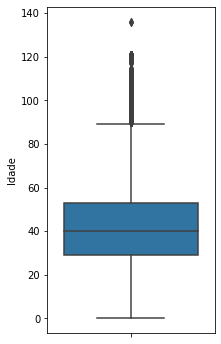

In [46]:
#Boxplot das idades (geral)
plt.figure(figsize=(3, 6))
sns.boxplot(y='Idade', data=df )

In [47]:
descricao = df['Idade'].describe().apply(lambda x: format(x, 'f'))
descricao

count    4100360.000000
mean          41.031705
std           17.500030
min            0.000000
25%           29.000000
50%           40.000000
75%           53.000000
max          136.000000
Name: Idade, dtype: object

In [48]:
Q1 = float(descricao[4])
Q2 = float(descricao[5])
Q3 = float(descricao[6])
limite_superior = Q3 + 1.5 * (Q3 - Q1)

Os dados com idades registradas acima do limite superior no boxplot são considerados outliers

In [49]:
limite_superior

89.0

A análise dos casos recuperados novamente bastante semelhante à análise dos casos em geral:

<AxesSubplot:ylabel='Idade'>

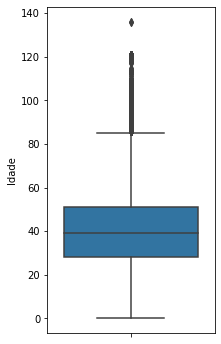

In [50]:
#Boxplot das idades (casos recuperados)
plt.figure(figsize=(3, 6))
sns.boxplot(y='Idade', data=df[df['Obito']==0] )

In [51]:
df[df['Obito']==0]['Idade'].describe().apply(lambda x: format(x, 'f'))

count    3957062.000000
mean          40.145079
std           16.914072
min            0.000000
25%           28.000000
50%           39.000000
75%           51.000000
max          136.000000
Name: Idade, dtype: object

<AxesSubplot:ylabel='Idade'>

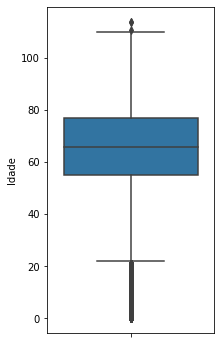

In [52]:
#Boxplot das idades (casos de óbitos)
plt.figure(figsize=(3, 6))
sns.boxplot(y='Idade', data=df[df['Obito']==1] )

In [53]:
descricao2 = df[df['Obito']==1]['Idade'].describe().apply(lambda x: format(x, 'f'))
descricao2

count    143298.000000
mean         65.515199
std          15.554730
min           0.000000
25%          55.000000
50%          66.000000
75%          77.000000
max         114.000000
Name: Idade, dtype: object

In [54]:
Q1 = float(descricao2[4])
Q2 = float(descricao2[5])
Q3 = float(descricao2[6])
limite_inferior = Q1 - 1.5 * (Q3 - Q1)
limite_inferior

22.0

Observando a situação das idades informadas:

In [55]:
idade = df['Idade'].value_counts().to_frame()

In [56]:
idade.reset_index(inplace=True)

In [57]:
idade.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122 entries, 0 to 121
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   122 non-null    float64
 1   Idade   122 non-null    int64  
dtypes: float64(1), int64(1)
memory usage: 2.0 KB


In [58]:
idade.columns = ['idade', 'quantidade']

In [59]:
# Mostrando por ordenação decrescente uma grande quantidade de idades não válidas:
idade.sort_values('idade', ascending=False).head(10)

,idade,quantidade
116,136.0,2
105,121.0,39
107,120.0,24
117,119.0,2
115,118.0,3
120,117.0,2
121,115.0,1
113,114.0,5
114,113.0,3
119,112.0,2


In [60]:
# Ordenação crescente das idades e suas respectivas quantidades de ocorrências nos dados:
idade.sort_values('idade').head(10)

,idade,quantidade
62,0.0,16244
68,1.0,13413
75,2.0,10770
79,3.0,9859
81,4.0,9269
78,5.0,10222
76,6.0,10621
73,7.0,11133
72,8.0,12203
71,9.0,12462


In [61]:
print('Levando em consideração o limite superior {0} para a distribuição geral de idades, foi decidido por remover do conjunto de dados os pacientes registrados com idade superior a esta.'.format(limite_superior))

Levando em consideração o limite superior 89.0 para a distribuição geral de idades, foi decidido por remover do conjunto de dados os pacientes registrados com idade superior a esta.


In [62]:
#Exclusão dos dados onde a idade é considerada outlier 
df.drop(df[df['Idade'] > limite_superior].index, inplace=True)

<AxesSubplot:ylabel='Idade'>

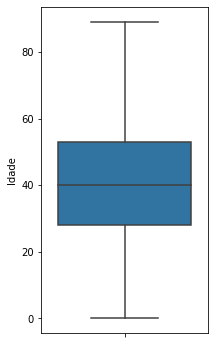

In [63]:
#Resultado da exclusão, não há mais outliers nos dados em geral
plt.figure(figsize=(3, 6))
sns.boxplot(y='Idade', data=df )

Já que o boxplot das idades para os casos de óbitos mostrou outliers antes do limite inferior, é analisada a situação dos óbitos referente à jovens e crianças com idade informada abaixo deste limite. Isso mostrará a importância dos individuos jovens no conjunto de dados.

In [64]:
df_temp = df[df['Obito'] == 0]

In [65]:
len(df_temp[df_temp['Idade']<limite_inferior])

499066

<AxesSubplot:>

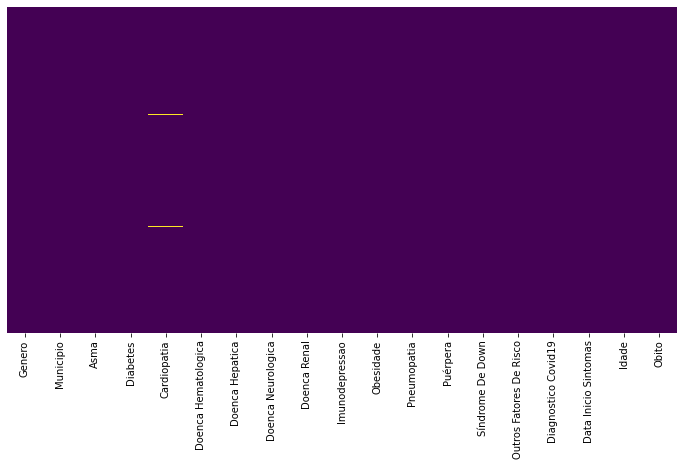

In [66]:
plt.figure(figsize=(12, 6))
sns.heatmap((df_temp[df_temp['Idade']<limite_inferior]=='SIM'), yticklabels=False, cbar=False, cmap='viridis')

In [67]:
df_temp = df[df['Obito'] == 1]

In [68]:
len(df_temp[df_temp['Idade']<limite_inferior])

490

<AxesSubplot:>

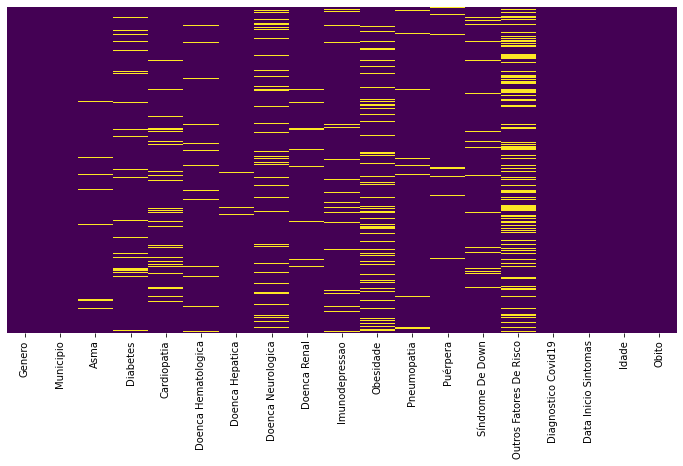

In [69]:
plt.figure(figsize=(12, 6))
sns.heatmap((df_temp[df_temp['Idade']<limite_inferior]=='SIM'), yticklabels=False, cbar=False, cmap='viridis')

O primeiro gráfico a seguir é o de óbitos em geral (novamente) e o segundo o de óbitos para os jovens abaixo da idade citada a seguir como lmite_inferior:

In [70]:
limite_inferior

22.0

(-1.1059245333031476,
 1.1081635501935696,
 -1.1081839124294137,
 1.1003897101156863)

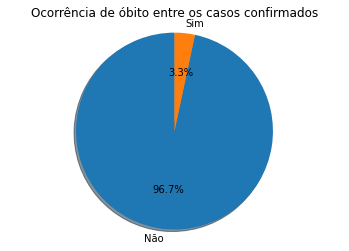

In [71]:
labels = 'Não', 'Sim'
sizes = df['Obito'].value_counts()

fig1, ax1 = plt.subplots()
plt.title('Ocorrência de óbito entre os casos confirmados')
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

(-1.1002407706839503,
 1.1006355253986333,
 -1.100419478981965,
 1.1000199753045292)

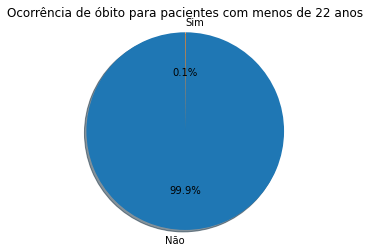

In [72]:
labels = 'Não', 'Sim'
sizes = df[df['Idade']<limite_inferior]['Obito'].value_counts()

fig1, ax1 = plt.subplots()
plt.title('Ocorrência de óbito para pacientes com menos de 22 anos')
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

Realmente a porcentagem de óbitos cai muito quando a idade é abaixo do limite citado. Optou-se então por excluir os dados onde a idade informada é considerada outlier quando analisado apenas os casos de óbitos, ou seja, abaixo do limite inferior do boxplot de idade para casos de óbitos

In [73]:
limite_inferior

22.0

In [74]:
descricao = df[(df['Obito']==1)&(df['Idade']<limite_inferior)]['Idade'].describe().apply(lambda x: format(x, 'f'))
descricao

count    490.000000
mean      13.177551
std        7.726082
min        0.000000
25%        6.000000
50%       16.000000
75%       20.000000
max       21.000000
Name: Idade, dtype: object

## Gênero 

Dada a porcentagem extremamente baixa de indivíduos com gênero informado como 'indefinido' ou 'ignorado', fica decidido removê-los também

In [75]:
df['Genero'].value_counts()

FEMININO      2165297
MASCULINO     1916280
INDEFINIDO       2149
IGNORADO           37
Name: Genero, dtype: int64

In [76]:
df['Genero'].value_counts(normalize=True)

FEMININO      0.530221
MASCULINO     0.469244
INDEFINIDO    0.000526
IGNORADO      0.000009
Name: Genero, dtype: float64

In [77]:
#Exclusão dos registros onde o gênero é "INDEFINIDO" ou "IGNORADO"
df.drop(df[(df['Genero'] == 'INDEFINIDO') | (df['Genero'] == 'IGNORADO')].index, inplace=True)

In [78]:
#Resultado da Exclusão
df['Genero'].value_counts()

FEMININO     2165297
MASCULINO    1916280
Name: Genero, dtype: int64

In [79]:
genero = df['Genero'].value_counts().to_frame()

(-1.110146257828768,
 1.120594461841415,
 -1.1086524516317477,
 1.1004120215062736)

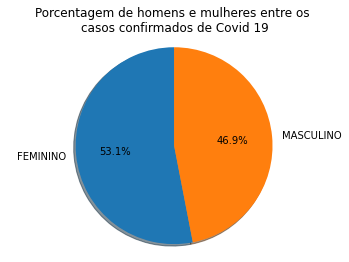

In [80]:
labels = genero.index
sizes = genero['Genero']

fig1, ax1 = plt.subplots()
plt.title('Porcentagem de homens e mulheres entre os \ncasos confirmados de Covid 19')
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

[Text(0.5, 1.0, 'Quantidade de Recuperados e Óbitos \npor Gênero Feminino e Masculino')]

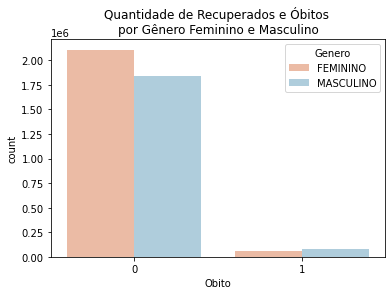

In [81]:
sns.countplot(x='Obito', data=df, hue='Genero', palette='RdBu' ).set(
    title='Quantidade de Recuperados e Óbitos \npor Gênero Feminino e Masculino')

[Text(0.5, 1.0, 'Recuperados e Óbitos \npor Gênero e Idade')]

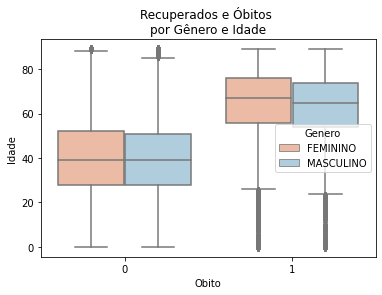

In [82]:
sns.boxplot(x='Obito', y='Idade', data=df, hue='Genero', palette='RdBu' ).set(
    title='Recuperados e Óbitos \npor Gênero e Idade')

<AxesSubplot:xlabel='Genero', ylabel='Idade'>

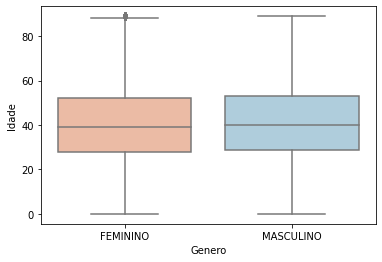

In [83]:
sns.boxplot(x='Genero', y='Idade', data=df, palette='RdBu' )

<AxesSubplot:xlabel='Genero', ylabel='Idade'>

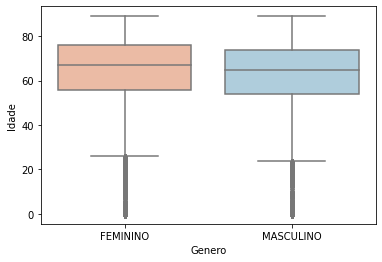

In [84]:
sns.boxplot(x='Genero', y='Idade', data=df[df['Obito']==1], palette='RdBu')

<AxesSubplot:xlabel='Genero', ylabel='Idade'>

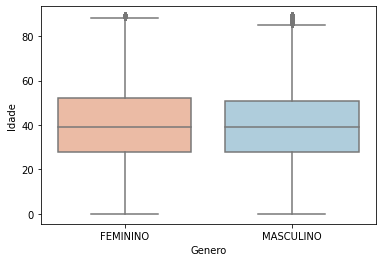

In [85]:
sns.boxplot(x='Genero', y='Idade', data=df[df['Obito']==0], palette='RdBu')

## Comorbidades

In [86]:
df.head()

,Genero,Municipio,Asma,Diabetes,Cardiopatia,Doenca Hematologica,Doenca Hepatica,Doenca Neurologica,Doenca Renal,Imunodepressao,Obesidade,Pneumopatia,Puérpera,Síndrome De Down,Outros Fatores De Risco,Diagnostico Covid19,Data Inicio Sintomas,Idade,Obito
0,FEMININO,SÃO PAULO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,CONFIRMADO,18/06/2021,32.0,0
1,FEMININO,SANTOS,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,CONFIRMADO,15/06/2021,15.0,0
2,FEMININO,SANTO ANDRÉ,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,CONFIRMADO,19/06/2020,32.0,0
3,FEMININO,SÃO PAULO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,CONFIRMADO,05/07/2020,41.0,0
4,FEMININO,CARAGUATATUBA,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,CONFIRMADO,26/01/2021,47.0,0


In [87]:
df.loc[(df['Asma'] == 'SIM') &
       (df['Diabetes'] == 'SIM') &
       (df['Cardiopatia'] == 'SIM') &
       (df['Doenca Hematologica'] == 'SIM') &
       (df['Doenca Hepatica'] == 'SIM') & 
       (df['Doenca Neurologica'] == 'SIM') &
       (df['Doenca Renal'] == 'SIM') &
       (df['Imunodepressao'] == 'SIM') &
       (df['Obesidade'] == 'SIM') &
       (df['Pneumopatia'] == 'SIM') &
       (df['Puérpera'] == 'SIM') &
       (df['Síndrome De Down'] == 'SIM') &
       (df['Outros Fatores De Risco'] == 'SIM'),
       'Comorbidade'] = 'SIM'

In [88]:
df.loc[(df['Asma'] == 'NÃO') &
       (df['Diabetes'] == 'NÃO') &
       (df['Cardiopatia'] == 'NÃO') &
       (df['Doenca Hematologica'] == 'NÃO') &
       (df['Doenca Hepatica'] == 'NÃO') & 
       (df['Doenca Neurologica'] == 'NÃO') &
       (df['Doenca Renal'] == 'NÃO') &
       (df['Imunodepressao'] == 'NÃO') &
       (df['Obesidade'] == 'NÃO') &
       (df['Pneumopatia'] == 'NÃO') &
       (df['Puérpera'] == 'NÃO') &
       (df['Síndrome De Down'] == 'NÃO') &
       (df['Outros Fatores De Risco'] == 'NÃO'),
       'Comorbidade'] = 'NÃO'

In [89]:
df.loc[(df['Asma'] == 'IGNORADO') &
       (df['Diabetes'] == 'IGNORADO') &
       (df['Cardiopatia'] == 'IGNORADO') &
       (df['Doenca Hematologica'] == 'IGNORADO') &
       (df['Doenca Hepatica'] == 'IGNORADO') & 
       (df['Doenca Neurologica'] == 'IGNORADO') &
       (df['Doenca Renal'] == 'IGNORADO') &
       (df['Imunodepressao'] == 'IGNORADO') &
       (df['Obesidade'] == 'IGNORADO') &
       (df['Pneumopatia'] == 'IGNORADO') &
       (df['Puérpera'] == 'IGNORADO') &
       (df['Síndrome De Down'] == 'IGNORADO') &
       (df['Outros Fatores De Risco'] == 'IGNORADO'),
       'Comorbidade'] = 'IGNORADO'

In [90]:
df["Comorbidade"].fillna("ALTERNADO", inplace = True) 

In [91]:
df['Comorbidade'].value_counts()

IGNORADO     3526136
ALTERNADO     555158
NÃO              279
SIM                4
Name: Comorbidade, dtype: int64

In [92]:
df['Comorbidade'].value_counts(normalize=True).apply(lambda x: format(x, 'f'))

IGNORADO     0.863915
ALTERNADO    0.136016
NÃO          0.000068
SIM          0.000001
Name: Comorbidade, dtype: object

Gráfico que analisa a completude das informações recebidas

(-1.1068167289970312,
 1.104019046327112,
 -1.1064045880764077,
 1.1003049803845908)

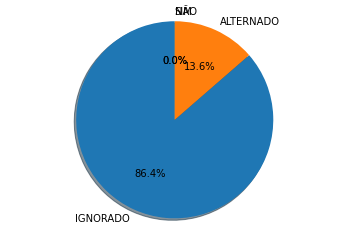

In [93]:
labels = df['Comorbidade'].unique()
sizes = df['Comorbidade'].value_counts()

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

Relembrando primeiro a poncentagem geral de óbitos nos dados, depois analisando a porcentagem para cada categoria de 'Comorbidade' gerada

(-1.1059262614485676,
 1.1081607452878537,
 -1.1081848152497156,
 1.1003897531071294)

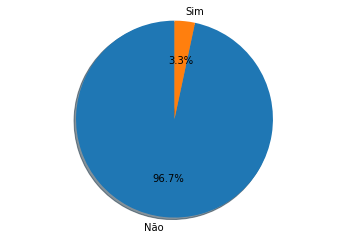

In [94]:
labels = 'Não', 'Sim'
sizes = df['Obito'].value_counts()

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

(-1.102404982931313, 1.1056365466808644, -1.103986463060929, 1.100189833495058)

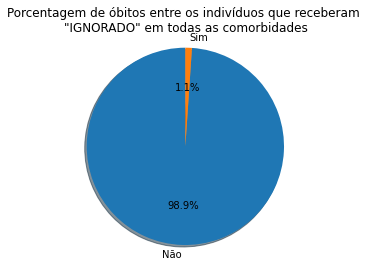

In [95]:
labels = 'Não', 'Sim'
sizes = df[df['Comorbidade'] == 'IGNORADO']['Obito'].value_counts()

fig1, ax1 = plt.subplots()
plt.title('Porcentagem de óbitos entre os indivíduos que receberam \n"IGNORADO" em todas as comorbidades')
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

(-1.1041893757437486,
 1.1060119088866527,
 -1.1058550499832294,
 1.1002788119039633)

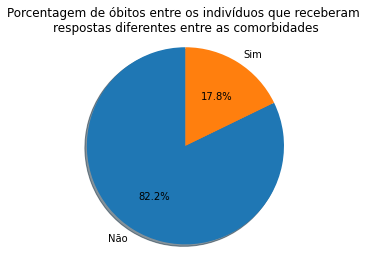

In [96]:
labels = 'Não', 'Sim'
sizes = df[df['Comorbidade'] == 'ALTERNADO']['Obito'].value_counts()

fig1, ax1 = plt.subplots()
plt.title('Porcentagem de óbitos entre os indivíduos que receberam \nrespostas diferentes entre as comorbidades')
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

(-1.103258236614202,
 1.1056328966093847,
 -1.1056932065113811,
 1.1002711050719705)

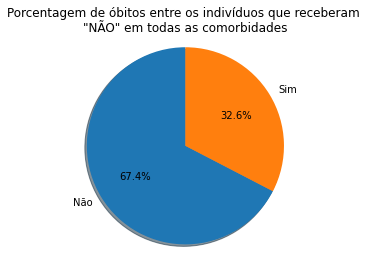

In [97]:
labels = 'Não', 'Sim'
sizes = df[df['Comorbidade'] == 'NÃO']['Obito'].value_counts()

fig1, ax1 = plt.subplots()
plt.title('Porcentagem de óbitos entre os indivíduos que receberam \n"NÃO" em todas as comorbidades')
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

(-1.120334176762862,
 1.1009682941315648,
 -1.120334176762862,
 1.1009682941315648)

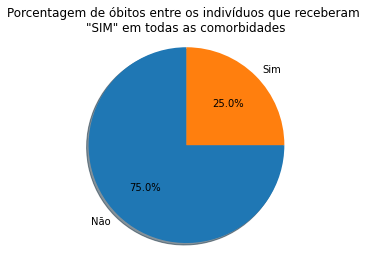

In [98]:
labels = 'Não', 'Sim'
sizes = df[df['Comorbidade'] == 'SIM']['Obito'].value_counts()

fig1, ax1 = plt.subplots()
plt.title('Porcentagem de óbitos entre os indivíduos que receberam \n"SIM" em todas as comorbidades')
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

In [99]:
df.drop('Comorbidade', axis=1, inplace=True)

In [100]:
df.loc[(df['Asma'] == 'SIM') | 
       (df['Diabetes'] == 'SIM') |
       (df['Cardiopatia'] == 'SIM') |
       (df['Doenca Hematologica'] == 'SIM') |
       (df['Doenca Hepatica'] == 'SIM') | 
       (df['Doenca Neurologica'] == 'SIM') |
       (df['Doenca Renal'] == 'SIM') |
       (df['Imunodepressao'] == 'SIM') |
       (df['Obesidade'] == 'SIM') |
       (df['Pneumopatia'] == 'SIM') |
       (df['Puérpera'] == 'SIM') |
       (df['Síndrome De Down'] == 'SIM') |
       (df['Outros Fatores De Risco'] == 'SIM'),
       'Comorbidade'] = 'SIM'

In [101]:
df["Comorbidade"].fillna("NÃO", inplace = True) 

In [102]:
df['Comorbidade'].value_counts()

NÃO    3526581
SIM     554996
Name: Comorbidade, dtype: int64

In [103]:
df['Comorbidade'].value_counts(normalize=True)

NÃO    0.864024
SIM    0.135976
Name: Comorbidade, dtype: float64

(-1.1068180392555458,
 1.1040672433864487,
 -1.10639581505867,
 1.1003045626218415)

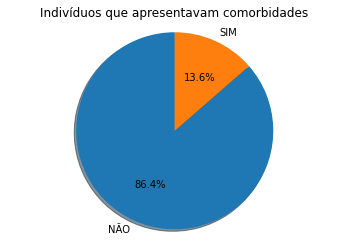

In [104]:
labels = df['Comorbidade'].unique()
sizes = df['Comorbidade'].value_counts()

fig1, ax1 = plt.subplots()
plt.title('Indivíduos que apresentavam comorbidades')
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

(-1.1041918133345263,
 1.1060098180261169,
 -1.105856857140803,
 1.1002788979590858)

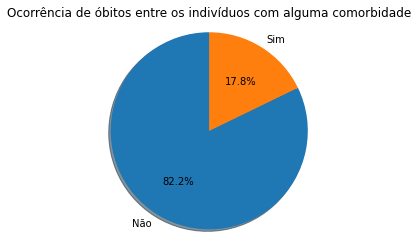

In [105]:
labels = 'Não', 'Sim'
sizes = df[df['Comorbidade'] == 'SIM']['Obito'].value_counts()

fig1, ax1 = plt.subplots()
plt.title('Ocorrência de óbitos entre os indivíduos com alguma comorbidade')
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

(-1.1024122377566226,
 1.1056506702086062,
 -1.103997664935363,
 1.1001903651345772)

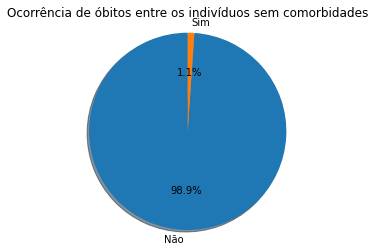

In [106]:
labels = 'Não', 'Sim'
sizes = df[df['Comorbidade'] == 'NÃO']['Obito'].value_counts()

fig1, ax1 = plt.subplots()
plt.title('Ocorrência de óbitos entre os indivíduos sem comorbidades')
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

In [107]:
df[(df['Asma'] == 'IGNORADO') & 
       (df['Diabetes'] == 'IGNORADO') &
       (df['Cardiopatia'] == 'IGNORADO') &
       (df['Doenca Hematologica'] == 'IGNORADO') &
       (df['Doenca Hepatica'] == 'IGNORADO') &
       (df['Doenca Neurologica'] == 'IGNORADO') &
       (df['Doenca Renal'] == 'IGNORADO') &
       (df['Imunodepressao'] == 'IGNORADO') &
       (df['Obesidade'] == 'IGNORADO') &
       (df['Pneumopatia'] == 'IGNORADO') &
       (df['Puérpera'] == 'IGNORADO') &
       (df['Síndrome De Down'] == 'IGNORADO') &
       (df['Outros Fatores De Risco'] == 'IGNORADO')]['Obito'].value_counts(normalize=True)

0    0.989315
1    0.010685
Name: Obito, dtype: float64

In [108]:
len(df) # com o drop a seguir é 555441 o tamanho, sem o drop é 4081577

4081577

In [109]:
df.drop(df[(df['Asma'] == 'IGNORADO') & 
       (df['Diabetes'] == 'IGNORADO') &
       (df['Cardiopatia'] == 'IGNORADO') &
       (df['Doenca Hematologica'] == 'IGNORADO') &
       (df['Doenca Hepatica'] == 'IGNORADO') &
       (df['Doenca Neurologica'] == 'IGNORADO') &
       (df['Doenca Renal'] == 'IGNORADO') &
       (df['Imunodepressao'] == 'IGNORADO') &
       (df['Obesidade'] == 'IGNORADO') &
       (df['Pneumopatia'] == 'IGNORADO') &
       (df['Puérpera'] == 'IGNORADO') &
       (df['Síndrome De Down'] == 'IGNORADO') &
       (df['Outros Fatores De Risco'] == 'IGNORADO')].index, inplace=True)

In [110]:
len(df) 

555441

<AxesSubplot:>

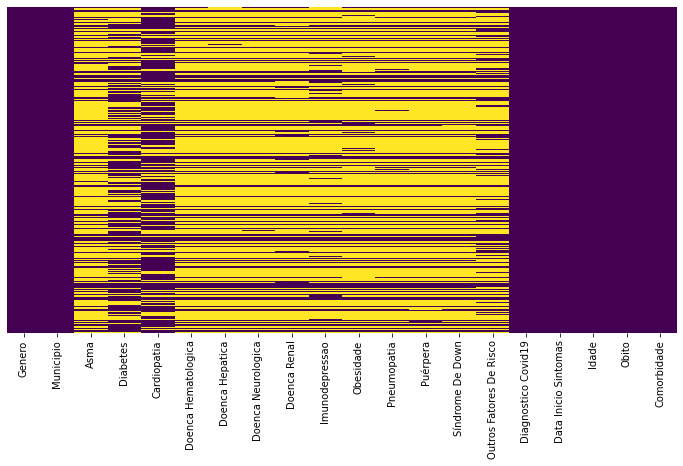

In [111]:
plt.figure(figsize=(12, 6))
sns.heatmap(df=='IGNORADO', yticklabels=False, cbar=False, cmap='viridis')

In [112]:
df.replace('IGNORADO', 'NÃO', inplace=True)

<AxesSubplot:>

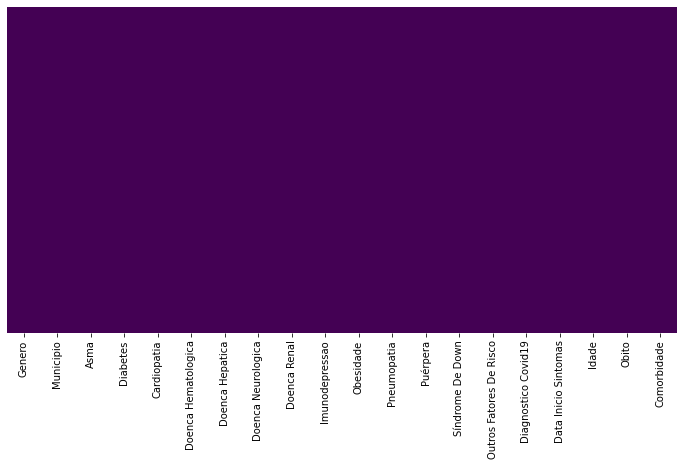

In [113]:
plt.figure(figsize=(12, 6))
sns.heatmap(df=='IGNORADO', yticklabels=False, cbar=False, cmap='viridis')

Será feito também a criação da coluna binária idade_avancada para ser usada posteriormente

In [114]:
def idade_avancada(idade):
    if idade >= idade_referencia:
        return 1
    else: 
        return 0

In [115]:
df['idade_avancada'] = df['Idade'].apply(idade_avancada)

In [116]:
df.to_csv(r'dados_tratados_1.csv', sep = ';', index=False)

## Geração do arquivo de dummies (1)

In [117]:
df = pd.read_csv(r'dados_tratados_1.csv', sep = ';')

In [118]:
df.head()

,Genero,Municipio,Asma,Diabetes,Cardiopatia,Doenca Hematologica,Doenca Hepatica,Doenca Neurologica,Doenca Renal,Imunodepressao,...,Pneumopatia,Puérpera,Síndrome De Down,Outros Fatores De Risco,Diagnostico Covid19,Data Inicio Sintomas,Idade,Obito,Comorbidade,idade_avancada
0,FEMININO,SÃO JOSÉ DOS CAMPOS,NÃO,SIM,SIM,NÃO,NÃO,NÃO,NÃO,NÃO,...,NÃO,NÃO,NÃO,NÃO,CONFIRMADO,17/05/2021,61.0,0,SIM,1
1,FEMININO,SÃO JOSÉ DOS CAMPOS,NÃO,NÃO,SIM,NÃO,NÃO,NÃO,NÃO,NÃO,...,NÃO,NÃO,NÃO,NÃO,CONFIRMADO,05/05/2021,41.0,0,SIM,0
2,FEMININO,OURINHOS,NÃO,NÃO,SIM,NÃO,NÃO,NÃO,NÃO,NÃO,...,NÃO,NÃO,NÃO,NÃO,CONFIRMADO,26/10/2020,54.0,0,SIM,0
3,FEMININO,SÃO PAULO,NÃO,SIM,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,...,NÃO,NÃO,NÃO,NÃO,CONFIRMADO,12/03/2021,53.0,0,SIM,0
4,FEMININO,CAMPINAS,NÃO,NÃO,SIM,NÃO,NÃO,NÃO,NÃO,NÃO,...,NÃO,NÃO,NÃO,NÃO,CONFIRMADO,17/07/2021,74.0,0,SIM,1


In [119]:
df.columns

Index(['Genero', 'Municipio', 'Asma', 'Diabetes', 'Cardiopatia',
       'Doenca Hematologica', 'Doenca Hepatica', 'Doenca Neurologica',
       'Doenca Renal', 'Imunodepressao', 'Obesidade', 'Pneumopatia',
       'Puérpera', 'Síndrome De Down', 'Outros Fatores De Risco',
       'Diagnostico Covid19', 'Data Inicio Sintomas', 'Idade', 'Obito',
       'Comorbidade', 'idade_avancada'],
      dtype='object')

In [120]:
genero = pd.get_dummies(df['Genero'], drop_first=True)
genero.head(2)

,MASCULINO
0,0
1,0


In [121]:
genero.columns=['Genero_Masculino']
genero.columns

Index(['Genero_Masculino'], dtype='object')

In [122]:
asma = pd.get_dummies(df['Asma'], drop_first=True)
asma.head(2)

,SIM
0,0
1,0


In [123]:
asma.columns=['Asma']
asma.columns

Index(['Asma'], dtype='object')

In [124]:
diabetes = pd.get_dummies(df['Diabetes'], drop_first=True)
diabetes.head(2)

,SIM
0,1
1,0


In [125]:
diabetes.columns=['Diabetes']
diabetes.columns

Index(['Diabetes'], dtype='object')

In [126]:
cardiopatia = pd.get_dummies(df['Cardiopatia'], drop_first=True) 
cardiopatia.head(2)

,SIM
0,1
1,1


In [127]:
cardiopatia.columns=['Cardiopatia']
cardiopatia.columns

Index(['Cardiopatia'], dtype='object')

In [128]:
doenca_hematologica = pd.get_dummies(df['Doenca Hematologica'], drop_first=True) 
doenca_hematologica.head(2)

,SIM
0,0
1,0


In [129]:
doenca_hematologica.columns=['Doenca Hematologica']
doenca_hematologica.columns

Index(['Doenca Hematologica'], dtype='object')

In [130]:
doenca_hepatica = pd.get_dummies(df['Doenca Hepatica'], drop_first=True)
doenca_hepatica.head(2)

,SIM
0,0
1,0


In [131]:
doenca_hepatica.columns=['Doenca Hepatica']
doenca_hepatica.columns

Index(['Doenca Hepatica'], dtype='object')

In [132]:
doenca_neurologica = pd.get_dummies(df['Doenca Neurologica'], drop_first=True) 
doenca_neurologica.head(2)

,SIM
0,0
1,0


In [133]:
doenca_neurologica.columns=['Doenca Neurologica']
doenca_neurologica.columns

Index(['Doenca Neurologica'], dtype='object')

In [134]:
doenca_renal = pd.get_dummies(df['Doenca Renal'], drop_first=True) 
doenca_renal.head(2)

,SIM
0,0
1,0


In [135]:
doenca_renal.columns=['Doenca Renal']
doenca_renal.columns

Index(['Doenca Renal'], dtype='object')

In [136]:
imunodepressao = pd.get_dummies(df['Imunodepressao'], drop_first=True) 
imunodepressao.head(2)

,SIM
0,0
1,0


In [137]:
imunodepressao.columns=['Imunodepressao']
imunodepressao.columns

Index(['Imunodepressao'], dtype='object')

In [138]:
obesidade = pd.get_dummies(df['Obesidade'], drop_first=True)
obesidade.head(2)

,SIM
0,0
1,0


In [139]:
obesidade.columns=['Obesidade']
obesidade.columns

Index(['Obesidade'], dtype='object')

In [140]:
pneumopatia = pd.get_dummies(df['Pneumopatia'], drop_first=True)
pneumopatia.head(2)

,SIM
0,0
1,0


In [141]:
pneumopatia.columns=['Pneumopatia']
pneumopatia.columns

Index(['Pneumopatia'], dtype='object')

In [142]:
puerpera = pd.get_dummies(df['Puérpera'], drop_first=True)
puerpera.head(2)

,SIM
0,0
1,0


In [143]:
puerpera.columns=['Puérpera']
puerpera.columns

Index(['Puérpera'], dtype='object')

In [144]:
sindrome_de_down = pd.get_dummies(df['Síndrome De Down'], drop_first=True)
sindrome_de_down.head(2)

,SIM
0,0
1,0


In [145]:
sindrome_de_down.columns=['Síndrome de Down']
sindrome_de_down.columns

Index(['Síndrome de Down'], dtype='object')

In [146]:
outros = pd.get_dummies(df['Outros Fatores De Risco'], drop_first=True)
outros.head(2)

,SIM
0,0
1,0


In [147]:
outros.columns=['Outros Fatores De Risco']
outros.columns

Index(['Outros Fatores De Risco'], dtype='object')

In [148]:
comorbidade = pd.get_dummies(df['Comorbidade'], drop_first=True)
comorbidade.head(2)

,SIM
0,1
1,1


In [149]:
comorbidade.columns=['Comorbidade']
comorbidade.columns

Index(['Comorbidade'], dtype='object')

In [150]:
idade_avancada = pd.get_dummies(df['idade_avancada'], drop_first=True) 
idade_avancada.head(2)

,1
0,1
1,0


In [151]:
idade_avancada.columns=['idade_avancada']
idade_avancada.columns

Index(['idade_avancada'], dtype='object')

In [152]:
obito = pd.get_dummies(df['Obito'], drop_first=True) 
obito.head(2)

,1
0,0
1,0


In [153]:
obito.columns=['Obito']
obito.columns

Index(['Obito'], dtype='object')

In [154]:
df = pd.concat([genero, asma, diabetes, cardiopatia, doenca_hematologica, doenca_hepatica, 
                   doenca_neurologica, doenca_renal, imunodepressao, obesidade, pneumopatia, 
                   puerpera, sindrome_de_down, outros, comorbidade, idade_avancada, obito], axis=1)

In [155]:
df.head()

,Genero_Masculino,Asma,Diabetes,Cardiopatia,Doenca Hematologica,Doenca Hepatica,Doenca Neurologica,Doenca Renal,Imunodepressao,Obesidade,Pneumopatia,Puérpera,Síndrome de Down,Outros Fatores De Risco,Comorbidade,idade_avancada,Obito
0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0


In [156]:
df.to_csv(r'dados_dummies_1.csv', sep = ';', index=False)

## Geração do arquivo de dummies (2) - Tratamento das faixas etárias

Procurando por uma forma de melhorar o modelo, ao invés de usar a informação binária sobre ser ou não de idade avançada, optou-se por criar uma faixa etária tentando descrever melhor a característica de idade para o modelo

In [157]:
df = pd.read_csv(r'dados_tratados_1.csv', sep = ';')

In [158]:
def faixa_etaria(idade):
    if idade <= 22:        
        return 'até 22 anos'
    elif idade >= 23 and idade < 30:
        return 'de 23 a 29 anos'
    elif idade >= 30 and idade < 40:
        return 'de 30 a 39 anos'
    elif idade >= 40 and idade < 50:
        return 'de 40 a 49 anos'
    elif idade >= 50 and idade < 60:
        return 'de 50 a 59 anos'
    elif idade >= 60 and idade < 70:
        return 'de 60 a 69 anos'
    elif idade >= 70 and idade < 80:
        return 'de 70 a 79 anos'  
    else: 
        return '80 anos ou mais'

In [159]:
df['faixa_etaria'] = df['Idade'].apply(faixa_etaria)

In [160]:
df.head()

,Genero,Municipio,Asma,Diabetes,Cardiopatia,Doenca Hematologica,Doenca Hepatica,Doenca Neurologica,Doenca Renal,Imunodepressao,...,Puérpera,Síndrome De Down,Outros Fatores De Risco,Diagnostico Covid19,Data Inicio Sintomas,Idade,Obito,Comorbidade,idade_avancada,faixa_etaria
0,FEMININO,SÃO JOSÉ DOS CAMPOS,NÃO,SIM,SIM,NÃO,NÃO,NÃO,NÃO,NÃO,...,NÃO,NÃO,NÃO,CONFIRMADO,17/05/2021,61.0,0,SIM,1,de 60 a 69 anos
1,FEMININO,SÃO JOSÉ DOS CAMPOS,NÃO,NÃO,SIM,NÃO,NÃO,NÃO,NÃO,NÃO,...,NÃO,NÃO,NÃO,CONFIRMADO,05/05/2021,41.0,0,SIM,0,de 40 a 49 anos
2,FEMININO,OURINHOS,NÃO,NÃO,SIM,NÃO,NÃO,NÃO,NÃO,NÃO,...,NÃO,NÃO,NÃO,CONFIRMADO,26/10/2020,54.0,0,SIM,0,de 50 a 59 anos
3,FEMININO,SÃO PAULO,NÃO,SIM,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,...,NÃO,NÃO,NÃO,CONFIRMADO,12/03/2021,53.0,0,SIM,0,de 50 a 59 anos
4,FEMININO,CAMPINAS,NÃO,NÃO,SIM,NÃO,NÃO,NÃO,NÃO,NÃO,...,NÃO,NÃO,NÃO,CONFIRMADO,17/07/2021,74.0,0,SIM,1,de 70 a 79 anos


In [161]:
df['faixa_etaria'].value_counts()

de 50 a 59 anos    136517
de 60 a 69 anos    129661
de 40 a 49 anos     94807
de 70 a 79 anos     82418
de 30 a 39 anos     49194
80 anos ou mais     40296
de 23 a 29 anos     13823
até 22 anos          8725
Name: faixa_etaria, dtype: int64

(-1.1071132274027455,
 1.1129903269229864,
 -1.115643579989082,
 1.1007449323804326)

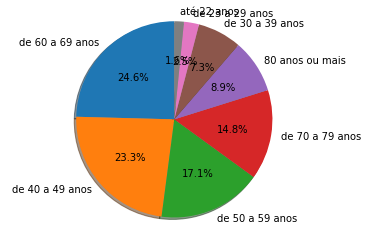

In [162]:
labels = df['faixa_etaria'].unique()
sizes = df['faixa_etaria'].value_counts()

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

[Text(0.5, 1.0, 'Quantidade de indivíduos em cada faixa etária')]

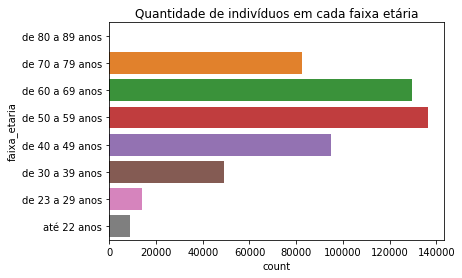

In [163]:
sns.countplot(y="faixa_etaria", data=df, order=['de 80 a 89 anos',
                                                'de 70 a 79 anos', 
                                                'de 60 a 69 anos',
                                                'de 50 a 59 anos',
                                                'de 40 a 49 anos',
                                                'de 30 a 39 anos',
                                                'de 23 a 29 anos',
                                                'até 22 anos']).set(title='Quantidade de indivíduos em cada faixa etária')

In [164]:
df.to_csv(r'dados_tratados_2.csv', sep = ';', index=False)

In [165]:
faixa_etaria = pd.get_dummies(df['faixa_etaria'], drop_first=True)

In [166]:
faixa_etaria.head()

,até 22 anos,de 23 a 29 anos,de 30 a 39 anos,de 40 a 49 anos,de 50 a 59 anos,de 60 a 69 anos,de 70 a 79 anos
0,0,0,0,0,0,1,0
1,0,0,0,1,0,0,0
2,0,0,0,0,1,0,0
3,0,0,0,0,1,0,0
4,0,0,0,0,0,0,1


In [167]:
df = pd.read_csv(r'dados_dummies_1.csv', sep = ';') #abre de novo os dados dummies para concatenar a faixa etaria

In [168]:
df.head()

,Genero_Masculino,Asma,Diabetes,Cardiopatia,Doenca Hematologica,Doenca Hepatica,Doenca Neurologica,Doenca Renal,Imunodepressao,Obesidade,Pneumopatia,Puérpera,Síndrome de Down,Outros Fatores De Risco,Comorbidade,idade_avancada,Obito
0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0


In [169]:
del df['idade_avancada']

In [170]:
len(faixa_etaria)

555441

In [171]:
len(df)

555441

In [172]:
df = pd.concat([df, faixa_etaria], axis=1)

In [173]:
df.head()

,Genero_Masculino,Asma,Diabetes,Cardiopatia,Doenca Hematologica,Doenca Hepatica,Doenca Neurologica,Doenca Renal,Imunodepressao,Obesidade,...,Outros Fatores De Risco,Comorbidade,Obito,até 22 anos,de 23 a 29 anos,de 30 a 39 anos,de 40 a 49 anos,de 50 a 59 anos,de 60 a 69 anos,de 70 a 79 anos
0,0,0,1,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
1,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1


In [174]:
df.to_csv(r'dados_dummies_2.csv', sep = ';', index=False)

## Geração do arquivo de dummies (3) - Tratamento de afunilamento do periodo escolhido 

In [175]:
df = pd.read_csv(r'dados_tratados_2.csv', sep = ';')

Com o intuito de tentar melhorar um pouco mais o modelo, optou-se por selecionar o período do segundo semestre do ano de 2020. A ideia é tentar evitar o início da pandemia, onte os testes de covid talvez não fossem tão precisos e também evitar dados onde pessoas já possam ter sido vacinadas, atrapalhando a predição. Basicamente, tentar selecionar um período mais específico.

In [176]:
def dentro_do_semestre(data_inicio_sintomas):
    dia = data_inicio_sintomas[:2]
    mes = data_inicio_sintomas[3:5]
    ano = data_inicio_sintomas[6:]
    data_inicio_sintomas = datetime.datetime(int(ano), int(mes), int(dia)) 
    if data_inicio_sintomas >= datetime.datetime(2020, 7, 1) and data_inicio_sintomas <= datetime.datetime(2020, 12, 31): 
        return True
    else: 
        return False

In [177]:
df['periodo_valido'] = df['Data Inicio Sintomas'].apply(dentro_do_semestre)

In [178]:
#Resultado da verificação de período

In [179]:
df['periodo_valido'].value_counts(normalize=True)

False    0.705063
True     0.294937
Name: periodo_valido, dtype: float64

In [180]:
df['periodo_valido'].value_counts()

False    391621
True     163820
Name: periodo_valido, dtype: int64

In [181]:
periodo_valido = df['periodo_valido']

In [182]:
#Exclusão dos dados fora do período válido
df.drop(df[df['periodo_valido'] == False].index, inplace=True)

In [183]:
df['periodo_valido'].value_counts()

True    163820
Name: periodo_valido, dtype: int64

In [184]:
#Exclusão da coluna, pois não será mais útil
df.drop('periodo_valido', axis=1, inplace=True)

In [185]:
df.to_csv(r'dados_tratados_3.csv', sep = ';', index=False)

In [186]:
len(df)

163820

In [187]:
df = pd.read_csv(r'dados_dummies_2.csv', sep = ';')

In [188]:
df = pd.concat([df, periodo_valido], axis=1)

In [189]:
df['periodo_valido'].value_counts(normalize=True)

False    0.705063
True     0.294937
Name: periodo_valido, dtype: float64

In [190]:
df['periodo_valido'].value_counts()

False    391621
True     163820
Name: periodo_valido, dtype: int64

In [191]:
#Exclusão dos dados fora do período válido
df.drop(df[df['periodo_valido'] == False].index, inplace=True)

In [192]:
df['periodo_valido'].value_counts()

True    163820
Name: periodo_valido, dtype: int64

In [193]:
#Exclusão da coluna, pois não será mais útil
df.drop('periodo_valido', axis=1, inplace=True)

In [194]:
df.to_csv(r'dados_dummies_3.csv', sep = ';', index=False) 

In [195]:
len(df)

163820

## Geração do arquivo de dummies (4) Quantidade de Comorbidades

A tentativa agora é ao invés de uma coluna binária informando se o indivíduo possue alguma comorbidade, informar quantas comorbidades que ele apresenta. Essa informação precisará se tornar categórica posteriormente. 

In [196]:
df = pd.read_csv(r'dados_dummies_3.csv', sep = ';')

In [197]:
df['qtd_comorbidades'] = df[['Asma', 'Diabetes', 'Cardiopatia',
       'Doenca Hematologica', 'Doenca Hepatica', 'Doenca Neurologica',
       'Doenca Renal', 'Imunodepressao', 'Obesidade', 'Pneumopatia',
       'Puérpera', 'Síndrome de Down', 'Outros Fatores De Risco']].sum(axis=1)

In [198]:
df.head()

,Genero_Masculino,Asma,Diabetes,Cardiopatia,Doenca Hematologica,Doenca Hepatica,Doenca Neurologica,Doenca Renal,Imunodepressao,Obesidade,...,Comorbidade,Obito,até 22 anos,de 23 a 29 anos,de 30 a 39 anos,de 40 a 49 anos,de 50 a 59 anos,de 60 a 69 anos,de 70 a 79 anos,qtd_comorbidades
0,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,1
1,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,1
2,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1
3,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,1
4,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,1,2


In [199]:
df['qtd_comorbidades'].value_counts()

1     109878
2      40551
3      10122
4       2539
5        471
0        118
6        106
7         17
9          6
8          6
12         3
11         2
13         1
Name: qtd_comorbidades, dtype: int64

Analisando com o boxplot a seguir, ficou decidido classificar a quantidade de comorbidades como "1", "2", "3" e "4 ou mais"

<AxesSubplot:ylabel='qtd_comorbidades'>

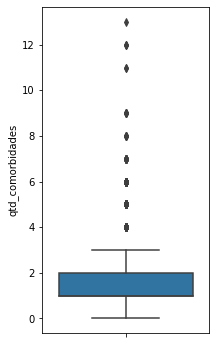

In [200]:
plt.figure(figsize=(3, 6))
sns.boxplot(y='qtd_comorbidades', data=df )

In [201]:
def categorizar_comorbidades(qtd_comorbidades):
    if qtd_comorbidades == 1:        
        return '1'
    elif qtd_comorbidades == 2:
        return '2'
    elif qtd_comorbidades == 3:
        return '3' 
    else: 
        return '4 ou mais'

In [202]:
df['qtd_comorbidades'] = df['qtd_comorbidades'].apply(categorizar_comorbidades)

In [203]:
df['qtd_comorbidades'].value_counts()

1            109878
2             40551
3             10122
4 ou mais      3269
Name: qtd_comorbidades, dtype: int64

In [204]:
df['qtd_comorbidades'].value_counts(normalize=True)

1            0.670724
2            0.247534
3            0.061787
4 ou mais    0.019955
Name: qtd_comorbidades, dtype: float64

(-1.1034043091010137,
 1.1353537534299347,
 -1.103353299591632,
 1.100159681189162)

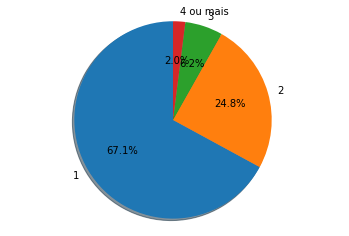

In [205]:
labels = df['qtd_comorbidades'].unique()
sizes = df['qtd_comorbidades'].value_counts()

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

In [206]:
qtd_comorbidades_tratada = df[['qtd_comorbidades']] #uma cópia para concatenar no arquivo de dados tratados

In [207]:
qtd_comorbidades = pd.get_dummies(df['qtd_comorbidades'], drop_first=True)

In [208]:
qtd_comorbidades.head()

,2,3,4 ou mais
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,1,0,0


In [209]:
qtd_comorbidades.columns = ['2_comorbidades', '3_comorbidades', '4_ou_mais']

In [210]:
df = pd.read_csv(r'dados_dummies_3.csv', sep = ';') #abre de novo os dados dummies para concatenar a faixa etaria

In [211]:
df.head()

,Genero_Masculino,Asma,Diabetes,Cardiopatia,Doenca Hematologica,Doenca Hepatica,Doenca Neurologica,Doenca Renal,Imunodepressao,Obesidade,...,Outros Fatores De Risco,Comorbidade,Obito,até 22 anos,de 23 a 29 anos,de 30 a 39 anos,de 40 a 49 anos,de 50 a 59 anos,de 60 a 69 anos,de 70 a 79 anos
0,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
2,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,1,0,0,...,1,1,0,0,0,0,0,0,0,1


In [212]:
df.columns

Index(['Genero_Masculino', 'Asma', 'Diabetes', 'Cardiopatia',
       'Doenca Hematologica', 'Doenca Hepatica', 'Doenca Neurologica',
       'Doenca Renal', 'Imunodepressao', 'Obesidade', 'Pneumopatia',
       'Puérpera', 'Síndrome de Down', 'Outros Fatores De Risco',
       'Comorbidade', 'Obito', 'até 22 anos', 'de 23 a 29 anos',
       'de 30 a 39 anos', 'de 40 a 49 anos', 'de 50 a 59 anos',
       'de 60 a 69 anos', 'de 70 a 79 anos'],
      dtype='object')

In [213]:
del df['Comorbidade'] # não será mais útil, estamos trocando a informação binária por uma de 4 categorias

In [214]:
len(qtd_comorbidades)

163820

In [215]:
len(df)

163820

In [216]:
df = pd.concat([df, qtd_comorbidades], axis=1)

In [217]:
df.head()

,Genero_Masculino,Asma,Diabetes,Cardiopatia,Doenca Hematologica,Doenca Hepatica,Doenca Neurologica,Doenca Renal,Imunodepressao,Obesidade,...,até 22 anos,de 23 a 29 anos,de 30 a 39 anos,de 40 a 49 anos,de 50 a 59 anos,de 60 a 69 anos,de 70 a 79 anos,2_comorbidades,3_comorbidades,4_ou_mais
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,1,0,0


In [218]:
df.columns

Index(['Genero_Masculino', 'Asma', 'Diabetes', 'Cardiopatia',
       'Doenca Hematologica', 'Doenca Hepatica', 'Doenca Neurologica',
       'Doenca Renal', 'Imunodepressao', 'Obesidade', 'Pneumopatia',
       'Puérpera', 'Síndrome de Down', 'Outros Fatores De Risco', 'Obito',
       'até 22 anos', 'de 23 a 29 anos', 'de 30 a 39 anos', 'de 40 a 49 anos',
       'de 50 a 59 anos', 'de 60 a 69 anos', 'de 70 a 79 anos',
       '2_comorbidades', '3_comorbidades', '4_ou_mais'],
      dtype='object')

In [219]:
df.to_csv(r'dados_dummies_4.csv', sep = ';', index=False)

In [220]:
df = pd.read_csv('dados_tratados_3.csv', sep = ';') # lê o mais recente para gerar um novo

In [221]:
df.head()

,Genero,Municipio,Asma,Diabetes,Cardiopatia,Doenca Hematologica,Doenca Hepatica,Doenca Neurologica,Doenca Renal,Imunodepressao,...,Puérpera,Síndrome De Down,Outros Fatores De Risco,Diagnostico Covid19,Data Inicio Sintomas,Idade,Obito,Comorbidade,idade_avancada,faixa_etaria
0,FEMININO,OURINHOS,NÃO,NÃO,SIM,NÃO,NÃO,NÃO,NÃO,NÃO,...,NÃO,NÃO,NÃO,CONFIRMADO,26/10/2020,54.0,0,SIM,0,de 50 a 59 anos
1,FEMININO,ARARAS,NÃO,SIM,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,...,NÃO,NÃO,NÃO,CONFIRMADO,30/12/2020,62.0,0,SIM,1,de 60 a 69 anos
2,FEMININO,SÃO PAULO,NÃO,SIM,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,...,NÃO,NÃO,NÃO,CONFIRMADO,11/08/2020,49.0,0,SIM,0,de 40 a 49 anos
3,FEMININO,MAUÁ,NÃO,NÃO,SIM,NÃO,NÃO,NÃO,NÃO,NÃO,...,NÃO,NÃO,NÃO,CONFIRMADO,05/12/2020,67.0,0,SIM,1,de 60 a 69 anos
4,FEMININO,PIRATININGA,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,SIM,NÃO,...,NÃO,NÃO,SIM,CONFIRMADO,02/12/2020,74.0,0,SIM,1,de 70 a 79 anos


In [222]:
df.columns

Index(['Genero', 'Municipio', 'Asma', 'Diabetes', 'Cardiopatia',
       'Doenca Hematologica', 'Doenca Hepatica', 'Doenca Neurologica',
       'Doenca Renal', 'Imunodepressao', 'Obesidade', 'Pneumopatia',
       'Puérpera', 'Síndrome De Down', 'Outros Fatores De Risco',
       'Diagnostico Covid19', 'Data Inicio Sintomas', 'Idade', 'Obito',
       'Comorbidade', 'idade_avancada', 'faixa_etaria'],
      dtype='object')

In [223]:
del df['Comorbidade'] # não será mais útil, estamos trocando a informação binária por uma de 4 categorias

In [224]:
len(qtd_comorbidades_tratada)

163820

In [225]:
len(df)

163820

In [226]:
df = pd.concat([df, qtd_comorbidades_tratada], axis=1)

In [227]:
df.head()

,Genero,Municipio,Asma,Diabetes,Cardiopatia,Doenca Hematologica,Doenca Hepatica,Doenca Neurologica,Doenca Renal,Imunodepressao,...,Puérpera,Síndrome De Down,Outros Fatores De Risco,Diagnostico Covid19,Data Inicio Sintomas,Idade,Obito,idade_avancada,faixa_etaria,qtd_comorbidades
0,FEMININO,OURINHOS,NÃO,NÃO,SIM,NÃO,NÃO,NÃO,NÃO,NÃO,...,NÃO,NÃO,NÃO,CONFIRMADO,26/10/2020,54.0,0,0,de 50 a 59 anos,1
1,FEMININO,ARARAS,NÃO,SIM,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,...,NÃO,NÃO,NÃO,CONFIRMADO,30/12/2020,62.0,0,1,de 60 a 69 anos,1
2,FEMININO,SÃO PAULO,NÃO,SIM,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,...,NÃO,NÃO,NÃO,CONFIRMADO,11/08/2020,49.0,0,0,de 40 a 49 anos,1
3,FEMININO,MAUÁ,NÃO,NÃO,SIM,NÃO,NÃO,NÃO,NÃO,NÃO,...,NÃO,NÃO,NÃO,CONFIRMADO,05/12/2020,67.0,0,1,de 60 a 69 anos,1
4,FEMININO,PIRATININGA,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,SIM,NÃO,...,NÃO,NÃO,SIM,CONFIRMADO,02/12/2020,74.0,0,1,de 70 a 79 anos,2


In [228]:
df.columns

Index(['Genero', 'Municipio', 'Asma', 'Diabetes', 'Cardiopatia',
       'Doenca Hematologica', 'Doenca Hepatica', 'Doenca Neurologica',
       'Doenca Renal', 'Imunodepressao', 'Obesidade', 'Pneumopatia',
       'Puérpera', 'Síndrome De Down', 'Outros Fatores De Risco',
       'Diagnostico Covid19', 'Data Inicio Sintomas', 'Idade', 'Obito',
       'idade_avancada', 'faixa_etaria', 'qtd_comorbidades'],
      dtype='object')

In [229]:
df['qtd_comorbidades'].value_counts()

1            109878
2             40551
3             10122
4 ou mais      3269
Name: qtd_comorbidades, dtype: int64

In [230]:
df.to_csv(r'dados_tratados_4.csv', sep = ';', index=False)

## Geração do arquivo de dummies (5) Balanceamento

As tentativas até agora de gerar um bom modelo preditivo de classificação trouxeram pouca ou nenhuma melhoria. Portanto a nova tentativa se basea em considerar balancear os dados. Um alto índice de acertos para os casos de recuperação porém baixo índice de acertos para o caso de óbitos mostra que o desbalanceamento dos dados pode estar impactando a capacidade do modelo de aprender sobre esses dados. Basicamente, o modelo recebe como amostra para treino um número muito maior de recuperados do que de óbitos, por isto aprende menos sobre os óbitos.

### Undersampling

Será utilizada para balanceamento dos dados a técnica de Undersampling

In [231]:
df = pd.read_csv(r'dados_dummies_4.csv', sep = ';')

In [232]:
len(df)

163820

In [233]:
df.head()

,Genero_Masculino,Asma,Diabetes,Cardiopatia,Doenca Hematologica,Doenca Hepatica,Doenca Neurologica,Doenca Renal,Imunodepressao,Obesidade,...,até 22 anos,de 23 a 29 anos,de 30 a 39 anos,de 40 a 49 anos,de 50 a 59 anos,de 60 a 69 anos,de 70 a 79 anos,2_comorbidades,3_comorbidades,4_ou_mais
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,1,0,0


In [234]:
# Conta as classes, mostrando o desbalanceamento
count_class_0, count_class_1 = df.Obito.value_counts()

In [235]:
count_class_0 

141350

In [236]:
count_class_1

22470

Class 0: 141350
Class 1: 22470
Proportion: 6.29 : 1


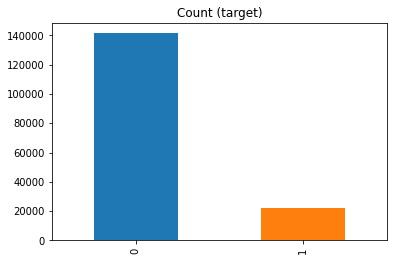

In [237]:
target_count = df.Obito.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')
target_count.plot(kind='bar', title='Count (target)',color = ['#1F77B4', '#FF7F0E']);

In [238]:
# Divide o dataset pelas duas classes
df_class_0 = df[df['Obito'] == 0]
df_class_1 = df[df['Obito'] == 1]

In [239]:
test_size=0.3
qtd_registros = int((1 - test_size) * len(df_class_1))

In [240]:
df_train_1 = df_class_1.iloc[:qtd_registros,:] # de forma não aleatória (para não perder o resto)
df_test_1 = df_class_1.iloc[qtd_registros:,:] # o restante vai para treino

In [241]:
df_train_0 = df_class_0.iloc[:qtd_registros,:] # de forma não aleatória (para não perder o resto)
df_test_0 = df_class_0.iloc[qtd_registros:,:] # o restante vai para treino

In [242]:
df_test = pd.concat([df_test_1, df_test_0], axis=0)

In [243]:
df_train = pd.concat([df_train_1, df_train_0], axis=0)

In [244]:
# comprovando ter amostras de treino do mesmo tamanho para ambas as classes alvo:

Random under-sampling:
1    15728
0    15728
Name: Obito, dtype: int64


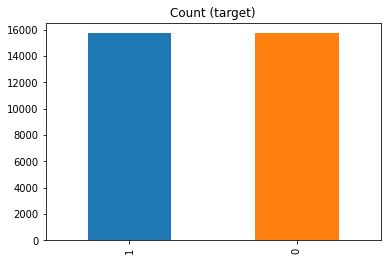

In [245]:
print('Random under-sampling:')
print(df_train.Obito.value_counts())
df_train.Obito.value_counts().plot(kind='bar', title='Count (target)',color = ['#1F77B4', '#FF7F0E']);

In [246]:
len(df_train) + len(df_test) # Mostrando que nenhum dado se perdeu 

163820

In [247]:
df_train.to_csv(r'dados_dummies_5_train.csv', sep = ';', index=False)

In [248]:
df_test.to_csv(r'dados_dummies_5_test.csv', sep = ';', index=False)

## Segundo conjunto de dados

In [249]:
df = pd.read_csv(r'dados_tratados_1.csv', sep = ';')

In [250]:
SP_municipios = json.load(open("geojs-35-mun.json", encoding="utf8")) # fonte: https://github.com/tbrugz/geodata-br

In [251]:
type(SP_municipios)

dict

In [252]:
len(SP_municipios)

2

In [253]:
SP_municipios.keys()

dict_keys(['type', 'features'])

In [254]:
type(SP_municipios["type"])

str

In [255]:
type(SP_municipios["features"])

list

In [256]:
len(SP_municipios["features"])

645

In [257]:
type(SP_municipios["features"][0])

dict

In [258]:
SP_municipios["features"][0].keys()

dict_keys(['type', 'properties', 'geometry'])

In [259]:
type(SP_municipios["features"][0]["type"])

str

In [260]:
SP_municipios["features"][0]["type"]

'Feature'

In [261]:
type(SP_municipios["features"][0]["properties"])

dict

In [262]:
SP_municipios["features"][0]["properties"]

{'id': '3500105', 'name': 'Adamantina', 'description': 'Adamantina'}

In [263]:
type(SP_municipios["features"][0]["geometry"])

dict

In [264]:
SP_municipios["features"][0]["geometry"]

{'type': 'Polygon',
 'coordinates': [[[-51.0578686748, -21.3988835488],
   [-51.0536454977, -21.4046228386],
   [-51.0450043489, -21.4037238276],
   [-51.045439432, -21.4063589008],
   [-51.0397224364, -21.4067760488],
   [-51.0330880762, -21.408863112],
   [-51.0247100808, -21.4208663742],
   [-51.0245845013, -21.4263462599],
   [-51.0033347502, -21.4385388237],
   [-50.9925874583, -21.4367999015],
   [-50.9911744426, -21.4418090183],
   [-50.9772464698, -21.4526305135],
   [-50.9674002039, -21.4750044331],
   [-50.9701364325, -21.4791879543],
   [-50.9651317696, -21.4838230857],
   [-50.9672264355, -21.4912547321],
   [-50.9644621647, -21.5045943621],
   [-50.9684617375, -21.5150857178],
   [-50.9639572448, -21.5215964229],
   [-50.9656099653, -21.5382668569],
   [-50.96736118, -21.5431056598],
   [-50.9739312904, -21.5459116694],
   [-50.9748171251, -21.5613375835],
   [-50.9712131933, -21.5685900545],
   [-50.9792266079, -21.5798515928],
   [-50.9783168617, -21.5907356849],
   [-51

In [265]:
SP_municipios["features"][0]["geometry"].keys()

dict_keys(['type', 'coordinates'])

In [266]:
def trata_nome(nome_municipio):
    return unidecode(nome_municipio).upper()

In [267]:
#Trata os municípios no dataframe:
df['Municipio'] = df['Municipio'].apply(trata_nome)

In [268]:
lista = []
#itera na lista de dicionarios 
for municipio in SP_municipios["features"]:    
    #Trata os municípios no dicionário:
    municipio["properties"]["name"] = trata_nome(municipio["properties"]["name"])
    municipio["id"] = municipio["properties"]["name"] #Cria os ids, pois não vieram no arquivo
    lista.append(municipio["id"])

In [269]:
df.head()

,Genero,Municipio,Asma,Diabetes,Cardiopatia,Doenca Hematologica,Doenca Hepatica,Doenca Neurologica,Doenca Renal,Imunodepressao,...,Pneumopatia,Puérpera,Síndrome De Down,Outros Fatores De Risco,Diagnostico Covid19,Data Inicio Sintomas,Idade,Obito,Comorbidade,idade_avancada
0,FEMININO,SAO JOSE DOS CAMPOS,NÃO,SIM,SIM,NÃO,NÃO,NÃO,NÃO,NÃO,...,NÃO,NÃO,NÃO,NÃO,CONFIRMADO,17/05/2021,61.0,0,SIM,1
1,FEMININO,SAO JOSE DOS CAMPOS,NÃO,NÃO,SIM,NÃO,NÃO,NÃO,NÃO,NÃO,...,NÃO,NÃO,NÃO,NÃO,CONFIRMADO,05/05/2021,41.0,0,SIM,0
2,FEMININO,OURINHOS,NÃO,NÃO,SIM,NÃO,NÃO,NÃO,NÃO,NÃO,...,NÃO,NÃO,NÃO,NÃO,CONFIRMADO,26/10/2020,54.0,0,SIM,0
3,FEMININO,SAO PAULO,NÃO,SIM,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,...,NÃO,NÃO,NÃO,NÃO,CONFIRMADO,12/03/2021,53.0,0,SIM,0
4,FEMININO,CAMPINAS,NÃO,NÃO,SIM,NÃO,NÃO,NÃO,NÃO,NÃO,...,NÃO,NÃO,NÃO,NÃO,CONFIRMADO,17/07/2021,74.0,0,SIM,1


In [270]:
df_municipios_json = pd.DataFrame (lista, columns = ['Municipio'])

In [271]:
df_municipios_json.head()

,Municipio
0,ADAMANTINA
1,ADOLFO
2,AGUAI
3,AGUAS DA PRATA
4,AGUAS DE LINDOIA


In [272]:
df_municipios_json["verificacao"] = 1

In [273]:
len(df_municipios_json)

645

In [274]:
df_municipios_csv = pd.DataFrame(df["Municipio"].value_counts())

In [275]:
df_municipios_csv.head()

,Municipio
SAO PAULO,143669
CAMPINAS,18238
SAO JOSE DO RIO PRETO,14026
SAO BERNARDO DO CAMPO,11169
GUARULHOS,11010


In [276]:
df_municipios_csv.reset_index(inplace=True)

In [277]:
df_municipios_csv.columns=['Municipio', 'qtd']

In [278]:
df_municipios_csv

,Municipio,qtd
0,SAO PAULO,143669
1,CAMPINAS,18238
2,SAO JOSE DO RIO PRETO,14026
3,SAO BERNARDO DO CAMPO,11169
4,GUARULHOS,11010
...,...,...
641,SANTANA DA PONTE PENSA,8
642,BORA,7
643,JERIQUARA,7
644,SAO JOAO DO PAU D'ALHO,7


In [279]:
#Aparentemente o conjunto de dados df tem 1 município a mais do que o geojson, vejamos qual é

In [280]:
df_merge = pd.merge(df_municipios_csv, df_municipios_json, how='left', on='Municipio')

In [281]:
len(df_merge)

646

In [282]:
apenas_no_csv = df_merge[df_merge['verificacao'].isnull()]

In [283]:
apenas_no_csv

,Municipio,qtd,verificacao
66,EMBU DAS ARTES,1455,NaN
87,MOGI MIRIM,1053,NaN
490,FLORINEA,54,NaN
557,NAO INFORMADO,36,NaN
562,SAO LUIZ DO PARAITINGA,34,NaN
609,ARCO IRIS,23,NaN


In [284]:
df_merge = pd.merge(df_municipios_json, df_municipios_csv, how='left', on='Municipio')

In [285]:
len(df_merge)

645

In [286]:
apenas_no_json = df_merge[df_merge['qtd'].isnull()]

In [287]:
apenas_no_json

,Municipio,verificacao,qtd
38,ARCO-IRIS,1,NaN
167,EMBU,1,NaN
184,FLORINIA,1,NaN
345,MOJI MIRIM,1,NaN
559,SAO LUIS DO PARAITINGA,1,NaN


Foram encontrados 4 nomes de municípios escritos de forma errada no geojson e "ARCO-ÍRIS" escrito sem o hífem nos dados abertos do estado de São Paulo. Também nos dados abertos, em 36 registros o município não foi informado. Os nomes corretos são: Embu das Artes (Lei nº 14.537, de 06 de setembro de 2011.) Mogi Mirim Florinea Sao luiz do paraitinga Arco-Iris

In [288]:
#Corrige o que estava errado no json
for municipio in SP_municipios["features"]:   
    nome = municipio["properties"]["name"]
    
    if nome == 'EMBU':
        nome = 'EMBU DAS ARTES'
    elif nome == 'FLORINIA':
        nome = 'FLORINEA'
    elif nome == 'MOJI MIRIM':
        nome = 'MOGI MIRIM'
    elif nome == 'SAO LUIS DO PARAITINGA':
        nome = 'SAO LUIZ DO PARAITINGA'
    
    municipio["properties"]["name"] = nome
    municipio["id"] = nome
    

In [289]:
#Corrige o que estava errado no csv
df.replace('ARCO IRIS', 'ARCO-IRIS', inplace=True)

In [290]:
#df.drop(df[df['Municipio'] == 'NAO INFORMADO'].index, inplace=True) #remove os registros sem município

In [291]:
# Dados corrigidos, o merge agora será exato

In [292]:
df.to_csv(r'dados_tratados_1.csv', sep = ';', index=False)

In [293]:
with open('municipios_tratados_geo.json', 'w') as salvar:
    json.dump(SP_municipios, salvar,  indent=4)

In [294]:
df['casos_confirmados'] = 1

In [295]:
agrupamento_municipio = df.groupby('Municipio')

In [296]:
df_mapa = agrupamento_municipio.sum().reset_index()

In [297]:
df_mapa['percent_obitos'] = df_mapa['Obito'] / df_mapa['casos_confirmados']

In [298]:
df_mapa.head()

,Municipio,Idade,Obito,idade_avancada,casos_confirmados,percent_obitos
0,ADAMANTINA,25486.0,91,200,441,0.206349
1,ADOLFO,4269.0,13,39,72,0.180556
2,AGUAI,17728.0,71,147,310,0.229032
3,AGUAS DA PRATA,5387.0,19,50,88,0.215909
4,AGUAS DE LINDOIA,10734.0,38,78,187,0.203209


In [299]:
df_mapa.to_csv(r'df_mapa.csv', sep = ';', index=False)

## Sobre os arquivos gerados

A respeito dos arquivos gerados durante tratamentos e processamento dos dados, os arquivos dummies são de conteúdo 0 e 1 para uso pelos modelos de Machine Learning. Já os arquivos de dados tratados são apenas para acompanhar essas versões de dummies. São para facilitar, caso se deseje analisar os dados usados por algum modelo. Os arquivos são como checkpoits para este projeto, de forma geral. 

Demais arquivos foram salvos para serem usados no desenvolvimento do painel, sem que fosse necessário refazer os tratamentos realizados.

Só para que não reste dúvidas, será mostrado a quantidade de registros e características de formação para os arquivos.

## Arquivos da tentativa 1

In [300]:
# primeira versão de tratamentos 

In [301]:
df = pd.read_csv(r'dados_tratados_1.csv', sep = ';')

In [302]:
len(df)

555441

In [303]:
df = pd.read_csv(r'dados_dummies_1.csv', sep = ';')

In [304]:
len(df)

555441

## Arquivos da tentativa 2

In [305]:
# segunda versão de tratamentos: incluindo faixas etárias (Não altera a quantidade de linhas)

In [306]:
df = pd.read_csv(r'dados_tratados_2.csv', sep = ';')

In [307]:
len(df)

555441

In [308]:
df = pd.read_csv(r'dados_dummies_2.csv', sep = ';')

In [309]:
len(df)

555441

## Arquivos da tentativa 3

In [310]:
# terceira versão de tratamentos: incluindo faixas etárias + semestre específico

In [311]:
df = pd.read_csv(r'dados_tratados_3.csv', sep = ';')

In [312]:
len(df)

163820

In [313]:
df = pd.read_csv(r'dados_dummies_3.csv', sep = ';')

In [314]:
len(df)

163820

## Arquivos da tentativa 4

In [315]:
# quarta versão de tratamentos: incluindo faixas etárias + semestre específico + coluna de quantidade de comorbidades

In [316]:
df = pd.read_csv(r'dados_tratados_4.csv', sep = ';')

In [317]:
len(df)

163820

In [318]:
df = pd.read_csv(r'dados_dummies_4.csv', sep = ';')

In [319]:
len(df)

163820

## Arquivos da tentativa 5

In [320]:
# quinta versão de tratamentos: 
# incluindo faixas etárias + semestre específico + coluna de quantidade de comorbidades + undersampling

In [321]:
# A quinta tentativa Por se tratar apenas de já definir quais dados serão pra treino e quais pra teste, 
# não foi criado um arquivo de dados tratados, considera-se o dados_tratados_4

In [322]:
df = pd.read_csv(r'dados_dummies_5_train.csv', sep = ';')

In [323]:
tam1 = len(df)
tam1

31456

In [324]:
df = pd.read_csv(r'dados_dummies_5_test.csv', sep = ';')

In [325]:
tam2 = len(df)
tam2

132364

In [326]:
tam1 + tam2

163820

Também foram gerados os arquivos para o painel, sendo eles:

municipios_tratados_geo.json, que é o mesmo arquivo baixado da internet, porém contém os id's incluídos e alguns nomes de municípios corrigidos. df_mapa, dados_grafico_idadeXobito e df_comorbidades_graficos_barras, criados a partir do dados_tratados_1 para serem usados na criação do painel

# Análise Exploratória

In [327]:
df = pd.read_csv(r'dados_tratados_1.csv', sep = ';')

In [328]:
grupo = df.groupby('Idade')

In [329]:
idadeXobito = grupo.sum().reset_index()

In [332]:
idadeXobito.columns

Index(['Idade', 'Obito', 'idade_avancada'], dtype='object')

In [334]:
del idadeXobito['idade_avancada']

In [335]:
idadeXobito.columns = ['Idade', 'Qtd_Obitos']

In [336]:
idadeXobito.corr() # Correlação positiva e bastante alta

,Idade,Qtd_Obitos
Idade,1.000000,0.875678
Qtd_Obitos,0.875678,1.000000


In [337]:
idadeXobito.head()

,Idade,Qtd_Obitos
0,0.0,42
1,1.0,7
2,2.0,7
3,3.0,7
4,4.0,3


No gráfico a seguir os pontos mostram a distribuição de idade nos casos de óbitos, porém é possível ver a correlação entre o aumento da idade e o aumento da quantidade de casos sendo uma correlação positiva e crescente indicada pela linha azul:

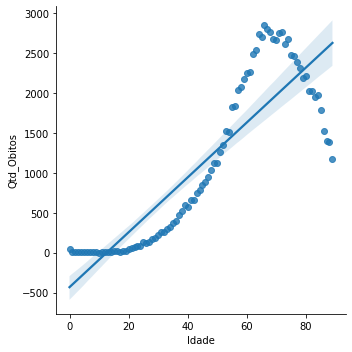

In [338]:
sns.lmplot(x='Idade', y='Qtd_Obitos', data=idadeXobito)

In [339]:
grupo.count().head()

,Genero,Municipio,Asma,Diabetes,Cardiopatia,Doenca Hematologica,Doenca Hepatica,Doenca Neurologica,Doenca Renal,Imunodepressao,Obesidade,Pneumopatia,Puérpera,Síndrome De Down,Outros Fatores De Risco,Diagnostico Covid19,Data Inicio Sintomas,Obito,Comorbidade,idade_avancada
Idade,,,,,,,,,,,,,,,,,,,,
0.0,642,642,642,642,642,642,642,642,642,642,642,642,642,642,642,642,642,642,642,642
1.0,289,289,289,289,289,289,289,289,289,289,289,289,289,289,289,289,289,289,289,289
2.0,192,192,192,192,192,192,192,192,192,192,192,192,192,192,192,192,192,192,192,192
3.0,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174
4.0,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146


In [340]:
idadeCount = grupo.count().reset_index()
idadeCount.head()

,Idade,Genero,Municipio,Asma,Diabetes,Cardiopatia,Doenca Hematologica,Doenca Hepatica,Doenca Neurologica,Doenca Renal,...,Obesidade,Pneumopatia,Puérpera,Síndrome De Down,Outros Fatores De Risco,Diagnostico Covid19,Data Inicio Sintomas,Obito,Comorbidade,idade_avancada
0,0.0,642,642,642,642,642,642,642,642,642,...,642,642,642,642,642,642,642,642,642,642
1,1.0,289,289,289,289,289,289,289,289,289,...,289,289,289,289,289,289,289,289,289,289
2,2.0,192,192,192,192,192,192,192,192,192,...,192,192,192,192,192,192,192,192,192,192
3,3.0,174,174,174,174,174,174,174,174,174,...,174,174,174,174,174,174,174,174,174,174
4,4.0,146,146,146,146,146,146,146,146,146,...,146,146,146,146,146,146,146,146,146,146


In [341]:
# Só pra conferir que posso usar qualquer campo que não tenha valores nulos se eu quiser um count do meu agrupamento
len(df[df['Idade'] == 22.0])

1208

In [342]:
idadeCount = idadeCount[['Idade', 'Genero']]

In [343]:
idadeCount.columns = ['Idade', 'Qtd_total']

In [344]:
df_idade = pd.merge(idadeCount, idadeXobito, how='inner', on='Idade'  )

In [345]:
df_idade.head()

,Idade,Qtd_total,Qtd_Obitos
0,0.0,642,42
1,1.0,289,7
2,2.0,192,7
3,3.0,174,7
4,4.0,146,3


In [346]:
df_idade['Percentual_Obitos'] = (df_idade['Qtd_Obitos'] / df_idade['Qtd_total']) * 100

Usando agora a porcentagem de óbitos em cada idade é mais fácil entender a correlação da idade avançada com a maior probabilidade de óbitos do que se for usado apenas a contagem dos casos de óbito, como feito no gráfico anterior. Observe:

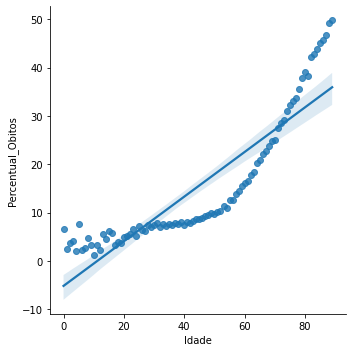

In [347]:
sns.lmplot(x='Idade', y='Percentual_Obitos', data=df_idade)

In [348]:
# exportar para colocar no dashboard
df_idade.to_csv('dados_grafico_idadeXobito.csv', sep = ';', index=False)

## Asma

In [349]:
df['Asma'].value_counts()

NÃO    543064
SIM     12377
Name: Asma, dtype: int64

In [350]:
df['Asma'].value_counts(normalize=True)

NÃO    0.977717
SIM    0.022283
Name: Asma, dtype: float64

In [351]:
df[df['Asma']=='SIM']['Obito'].value_counts(normalize=True)

0    0.748727
1    0.251273
Name: Obito, dtype: float64

(-1.1044713405772661,
 1.1085386667920727,
 -1.1068566677269283,
 1.1003265079869966)

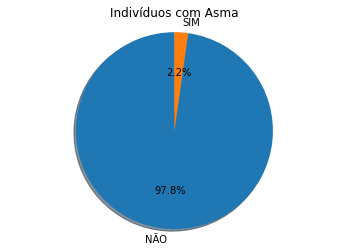

In [352]:
labels = df['Asma'].unique()
sizes = df['Asma'].value_counts()

fig1, ax1 = plt.subplots()
plt.title('Indivíduos com Asma')
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

(-1.120315449904011, 1.102039477560273, -1.120243422436326, 1.1009639983897697)

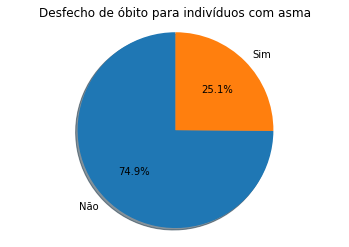

In [353]:
labels = 'Não', 'Sim'
sizes = df[df['Asma']=='SIM']['Obito'].value_counts()

fig1, ax1 = plt.subplots()
plt.title('Desfecho de óbito para indivíduos com asma')
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

## Diabetes 

In [354]:
df['Diabetes'].value_counts()

NÃO    333923
SIM    221518
Name: Diabetes, dtype: int64

In [355]:
df['Diabetes'].value_counts(normalize=True)

NÃO    0.601185
SIM    0.398815
Name: Diabetes, dtype: float64

In [356]:
df[df['Diabetes']=='SIM']['Obito'].value_counts(normalize=True)

0    0.809262
1    0.190738
Name: Obito, dtype: float64

(-1.1138761277017493,
 1.118155876983428,
 -1.1130201289129495,
 1.1006200474346641)

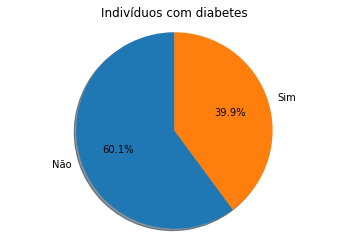

In [357]:
labels = ['Não', 'Sim']
sizes = df['Diabetes'].value_counts()

fig1, ax1 = plt.subplots()
plt.title('Indivíduos com diabetes')
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

(-1.1020682534087929,
 1.1046039155845186,
 -1.1033586108405709,
 1.100159953586514)

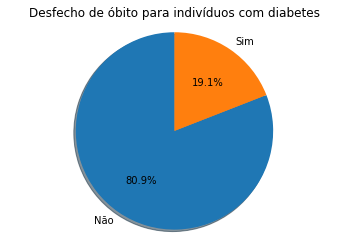

In [358]:
labels = 'Não', 'Sim'
sizes = df[df['Diabetes']=='SIM']['Obito'].value_counts()

fig1, ax1 = plt.subplots()
plt.title('Desfecho de óbito para indivíduos com diabetes')
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

## Cardiopatia

In [359]:
df['Cardiopatia'].value_counts()

SIM    336155
NÃO    219286
Name: Cardiopatia, dtype: int64

In [360]:
df['Cardiopatia'].value_counts(normalize=True)

SIM    0.605204
NÃO    0.394796
Name: Cardiopatia, dtype: float64

In [361]:
df[df['Cardiopatia']=='SIM']['Obito'].value_counts(normalize=True)

0    0.830477
1    0.169523
Name: Obito, dtype: float64

(-1.1140223807880512,
 1.1193730930328052,
 -1.1128083372539415,
 1.1006099208216162)

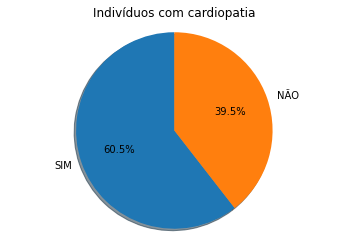

In [362]:
labels = df['Cardiopatia'].unique()
sizes = df['Cardiopatia'].value_counts()

fig1, ax1 = plt.subplots()
plt.title('Indivíduos com cardiopatia')
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

(-1.1052215407498347,
 1.1056838764673984,
 -1.1061475729076786,
 1.1002927415670323)

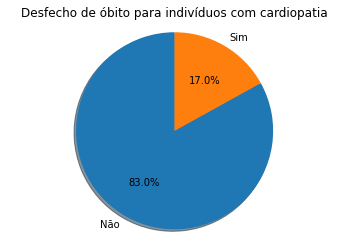

In [363]:
labels = 'Não', 'Sim'
sizes = df[df['Cardiopatia']=='SIM']['Obito'].value_counts()

fig1, ax1 = plt.subplots()
plt.title('Desfecho de óbito para indivíduos com cardiopatia')
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

## Doença Hematológica 

In [364]:
df['Doenca Hematologica'].value_counts()

NÃO    552389
SIM      3052
Name: Doenca Hematologica, dtype: int64

In [365]:
df['Doenca Hematologica'].value_counts(normalize=True)

NÃO    0.994505
SIM    0.005495
Name: Doenca Hematologica, dtype: float64

In [366]:
df[df['Doenca Hematologica']=='SIM']['Obito'].value_counts(normalize=True)

0    0.584862
1    0.415138
Name: Obito, dtype: float64

(-1.1012966824950399,
 1.1032526660870483,
 -1.1022104722567307,
 1.100105261306774)

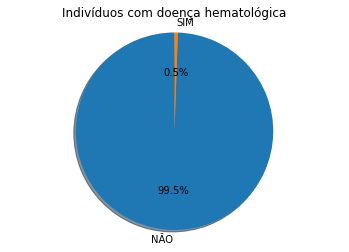

In [367]:
labels = df['Doenca Hematologica'].unique()
sizes = df['Doenca Hematologica'].value_counts()

fig1, ax1 = plt.subplots()
plt.title('Indivíduos com doença hematológica')
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

(-1.1126094580112698,
 1.1241090260286188,
 -1.1090527344919363,
 1.1004311256095574)

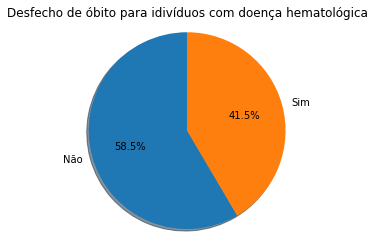

In [368]:
labels = 'Não', 'Sim'
sizes = df[df['Doenca Hematologica']=='SIM']['Obito'].value_counts()

fig1, ax1 = plt.subplots()
plt.title('Desfecho de óbito para idivíduos com doença hematológica')
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

## Doença Neurológica

In [369]:
df['Doenca Neurologica'].value_counts()

NÃO    541630
SIM     13811
Name: Doenca Neurologica, dtype: int64

In [370]:
df['Doenca Neurologica'].value_counts(normalize=True)

NÃO    0.975135
SIM    0.024865
Name: Doenca Neurologica, dtype: float64

In [371]:
df[df['Doenca Neurologica']=='SIM']['Obito'].value_counts(normalize=True)

1    0.503439
0    0.496561
Name: Obito, dtype: float64

(-1.104854153193414,
 1.1087282495937818,
 -1.1072888576970343,
 1.1003470910160735)

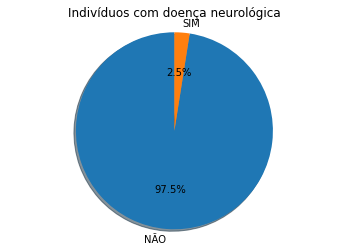

In [372]:
labels = df['Doenca Neurologica'].unique()
sizes = df['Doenca Neurologica'].value_counts()

fig1, ax1 = plt.subplots()
plt.title('Indivíduos com doença neurológica')
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

(-1.1015781222904903,
 1.1029937641444194,
 -1.1027549019417298,
 1.1001312374479337)

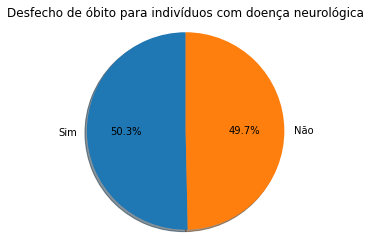

In [373]:
labels = 'Sim', 'Não'
sizes = df[df['Doenca Neurologica']=='SIM']['Obito'].value_counts()

fig1, ax1 = plt.subplots()
plt.title('Desfecho de óbito para indivíduos com doença neurológica')
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

## Doença Renal

In [374]:
df['Doenca Renal'].value_counts()

NÃO    533410
SIM     22031
Name: Doenca Renal, dtype: int64

In [375]:
df['Doenca Renal'].value_counts(normalize=True)

NÃO    0.960336
SIM    0.039664
Name: Doenca Renal, dtype: float64

In [376]:
df[df['Doenca Renal']=='SIM']['Obito'].value_counts(normalize=True)

0    0.672144
1    0.327856
Name: Obito, dtype: float64

(-1.1065059444564074,
 1.1066075090096672,
 -1.1083121025167344,
 1.1003958164432504)

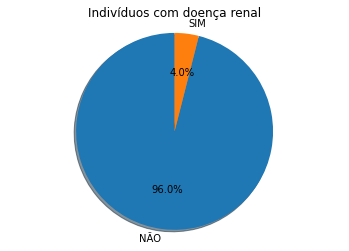

In [377]:
labels = df['Doenca Renal'].unique()
sizes = df['Doenca Renal'].value_counts()

fig1, ax1 = plt.subplots()
plt.title('Indivíduos com doença renal')
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

(-1.1025167687038055,
 1.1044376411554753,
 -1.104446131215118,
 1.1002117543945953)

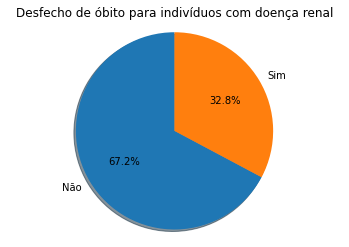

In [378]:
labels = 'Não', 'Sim'
sizes = df[df['Doenca Renal']=='SIM']['Obito'].value_counts()

fig1, ax1 = plt.subplots()
plt.title('Desfecho de óbito para indivíduos com doença renal')
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

## Imunodepressão

In [379]:
df['Imunodepressao'].value_counts()

NÃO    528853
SIM     26588
Name: Imunodepressao, dtype: int64

In [380]:
df['Imunodepressao'].value_counts(normalize=True)

NÃO    0.952132
SIM    0.047868
Name: Imunodepressao, dtype: float64

In [381]:
df[df['Imunodepressao']=='SIM']['Obito'].value_counts(normalize=True)

0    0.837558
1    0.162442
Name: Obito, dtype: float64

(-1.1072670047175468,
 1.1081948210080568,
 -1.1078122415264389,
 1.1003720176501062)

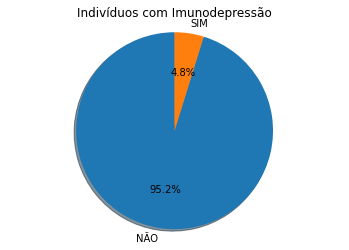

In [382]:
labels = df['Imunodepressao'].unique()
sizes = df['Imunodepressao'].value_counts()

fig1, ax1 = plt.subplots()
plt.title('Indivíduos com Imunodepressão')
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

(-1.1059478104536828,
 1.1065871744898716,
 -1.1055554546025066,
 1.1002645454572622)

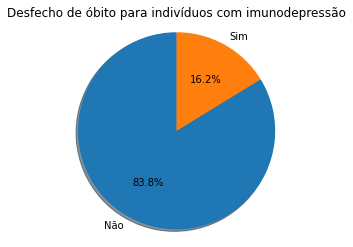

In [383]:
labels = 'Não', 'Sim'
sizes = df[df['Imunodepressao']=='SIM']['Obito'].value_counts()

fig1, ax1 = plt.subplots()
plt.title('Desfecho de óbito para indivíduos com imunodepressão')
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

## Obesidade

In [384]:
df['Obesidade'].value_counts()

NÃO    515065
SIM     40376
Name: Obesidade, dtype: int64

In [385]:
df['Obesidade'].value_counts(normalize=True)

NÃO    0.927308
SIM    0.072692
Name: Obesidade, dtype: float64

In [386]:
df[df['Obesidade']=='SIM']['Obito'].value_counts(normalize=True)

0    0.640925
1    0.359075
Name: Obito, dtype: float64

(-1.1078438346488462,
 1.1028833534494262,
 -1.1076358162164364,
 1.1003636102960208)

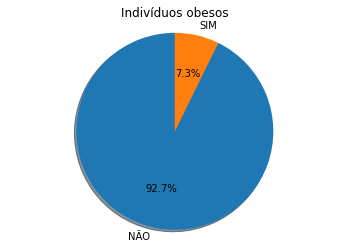

In [387]:
labels = df['Obesidade'].unique()
sizes = df['Obesidade'].value_counts()

fig1, ax1 = plt.subplots()
plt.title('Indivíduos obesos')
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

(-1.109582242927518, 1.116748811667863, -1.113715536744547, 1.1006531207973593)

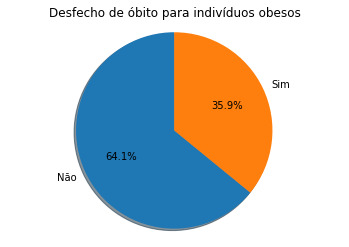

In [388]:
labels = 'Não', 'Sim'
sizes = df[df['Obesidade']=='SIM']['Obito'].value_counts()

fig1, ax1 = plt.subplots()
plt.title('Desfecho de óbito para indivíduos obesos')
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

## Pneumopatia

In [389]:
df['Pneumopatia'].value_counts()

NÃO    542324
SIM     13117
Name: Pneumopatia, dtype: int64

In [390]:
df['Pneumopatia'].value_counts(normalize=True)

NÃO    0.976385
SIM    0.023615
Name: Pneumopatia, dtype: float64

In [391]:
df[df['Pneumopatia']=='SIM']['Obito'].value_counts(normalize=True)

0    0.526035
1    0.473965
Name: Obito, dtype: float64

(-1.1046723997867618,
 1.108657264381949,
 -1.1070891039559543,
 1.100337576378855)

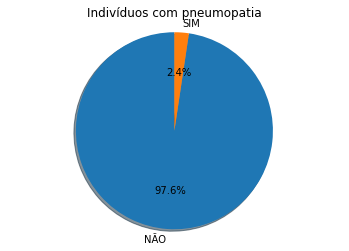

In [392]:
labels = df['Pneumopatia'].unique()
sizes = df['Pneumopatia'].value_counts()

fig1, ax1 = plt.subplots()
plt.title('Indivíduos com pneumopatia')
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

(-1.1092037568804896,
 1.1184188787684122,
 -1.1096150391296378,
 1.1004578590061733)

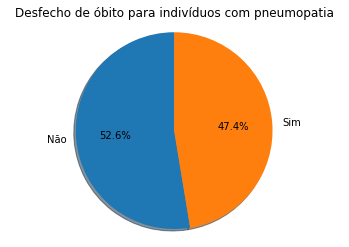

In [393]:
labels = 'Não', 'Sim'
sizes = df[df['Pneumopatia']=='SIM']['Obito'].value_counts()

fig1, ax1 = plt.subplots()
plt.title('Desfecho de óbito para indivíduos com pneumopatia')
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

## Puérpera

In [394]:
df['Puérpera'].value_counts()

NÃO    554219
SIM      1222
Name: Puérpera, dtype: int64

In [395]:
df['Puérpera'].value_counts(normalize=True)

NÃO    0.9978
SIM    0.0022
Name: Puérpera, dtype: float64

In [396]:
df[df['Puérpera']=='SIM']['Obito'].value_counts(normalize=True)

0    0.798691
1    0.201309
Name: Obito, dtype: float64

(-1.1005344177569942,
 1.1013922515043044,
 -1.100925822263499,
 1.1000440867744523)

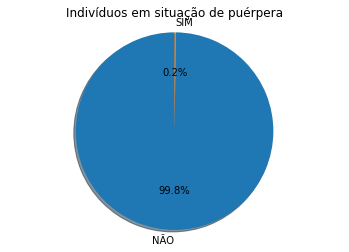

In [397]:
labels = df['Puérpera'].unique()
sizes = df['Puérpera'].value_counts()

fig1, ax1 = plt.subplots()
plt.title('Indivíduos em situação de puérpera')
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

(-1.1003182357541377,
 1.1008304467848624,
 -1.100551706536875,
 1.1000262717398512)

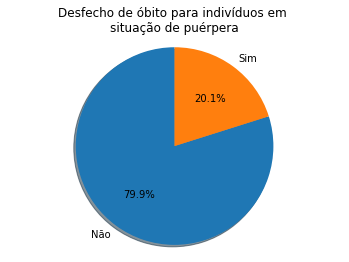

In [398]:
labels = 'Não', 'Sim'
sizes = df[df['Puérpera']=='SIM']['Obito'].value_counts()

fig1, ax1 = plt.subplots()
plt.title('Desfecho de óbito para indivíduos em \nsituação de puérpera')
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

## Síndrome de Down

In [399]:
df['Síndrome De Down'].value_counts()

NÃO    554250
SIM      1191
Name: Síndrome De Down, dtype: int64

In [400]:
df['Síndrome De Down'].value_counts(normalize=True)

NÃO    0.997856
SIM    0.002144
Name: Síndrome De Down, dtype: float64

In [401]:
df[df['Síndrome De Down']=='SIM']['Obito'].value_counts(normalize=True)

0    0.628044
1    0.371956
Name: Obito, dtype: float64

(-1.1005211028991064,
 1.1013583929515296,
 -1.1009029929978726,
 1.1000430000313337)

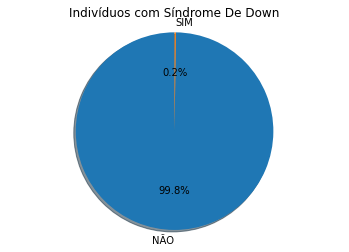

In [402]:
labels = df['Síndrome De Down'].unique()
sizes = df['Síndrome De Down'].value_counts()

fig1, ax1 = plt.subplots()
plt.title('Indivíduos com Síndrome De Down')
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

(-1.112372751433517, 1.12047581465815, -1.1140630045721498, 1.100669666884388)

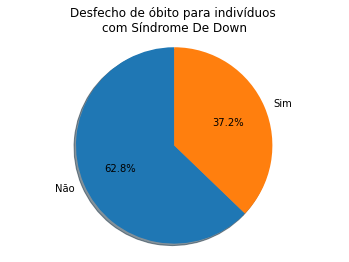

In [403]:
labels = 'Não', 'Sim'
sizes = df[df['Síndrome De Down']=='SIM']['Obito'].value_counts()

fig1, ax1 = plt.subplots()
plt.title('Desfecho de óbito para indivíduos \ncom Síndrome De Down')
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

## Idade Avançada

In [404]:
df['idade_avancada'].value_counts()

0    303066
1    252375
Name: idade_avancada, dtype: int64

In [405]:
df['idade_avancada'].value_counts(normalize=True)

0    0.545631
1    0.454369
Name: idade_avancada, dtype: float64

In [406]:
df[df['idade_avancada']==1]['Obito'].value_counts(normalize=True)

0    0.72716
1    0.27284
Name: Obito, dtype: float64

(-1.1119433639396057,
 1.1258028426599411,
 -1.1107392872678232,
 1.100511394631801)

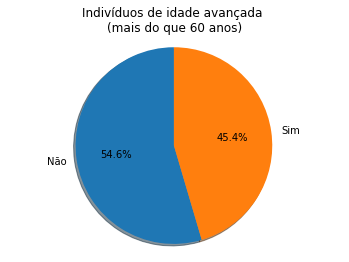

In [407]:
labels = ['Não', 'Sim']
sizes = df['idade_avancada'].value_counts()

fig1, ax1 = plt.subplots()
plt.title('Indivíduos de idade avançada \n(mais do que 60 anos)')
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

(-1.1184496936447375,
 1.1115949841689745,
 -1.1142169907036024,
 1.1006769995573145)

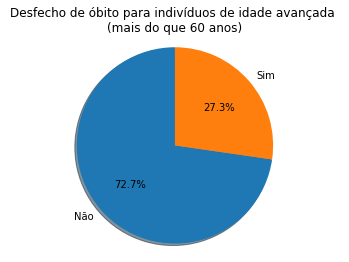

In [408]:
labels = 'Não', 'Sim'
sizes = df[df['idade_avancada']==1]['Obito'].value_counts()

fig1, ax1 = plt.subplots()
plt.title('Desfecho de óbito para indivíduos de idade avançada \n(mais do que 60 anos)')
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

In [409]:
len(df)

555441

## Outros Fatores de Risco

In [410]:
df['Outros Fatores De Risco'].value_counts()

NÃO    444404
SIM    111037
Name: Outros Fatores De Risco, dtype: int64

In [411]:
df['Outros Fatores De Risco'].value_counts(normalize=True)

NÃO    0.800092
SIM    0.199908
Name: Outros Fatores De Risco, dtype: float64

In [412]:
df[df['Outros Fatores De Risco']=='SIM']['Obito'].value_counts(normalize=True)

0    0.63822
1    0.36178
Name: Obito, dtype: float64

(-1.1000227644725757,
 1.100060615207862,
 -1.1000398120395092,
 1.1000018958114053)

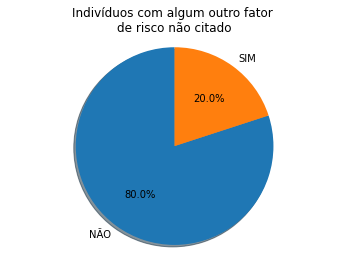

In [413]:
labels = df['Outros Fatores De Risco'].unique()
sizes = df['Outros Fatores De Risco'].value_counts()

fig1, ax1 = plt.subplots()
plt.title('Indivíduos com algum outro fator \nde risco não citado')
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

(-1.110279510874431,
 1.1177907196054173,
 -1.1141496668508242,
 1.1006738310678237)

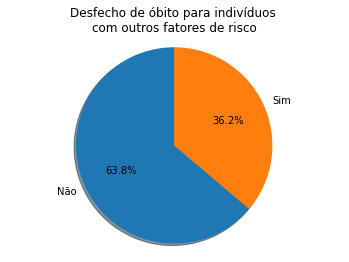

In [414]:
labels = 'Não', 'Sim'
sizes = df[df['Outros Fatores De Risco']=='SIM']['Obito'].value_counts()

fig1, ax1 = plt.subplots()
plt.title('Desfecho de óbito para indivíduos \ncom outros fatores de risco')
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

<AxesSubplot:>

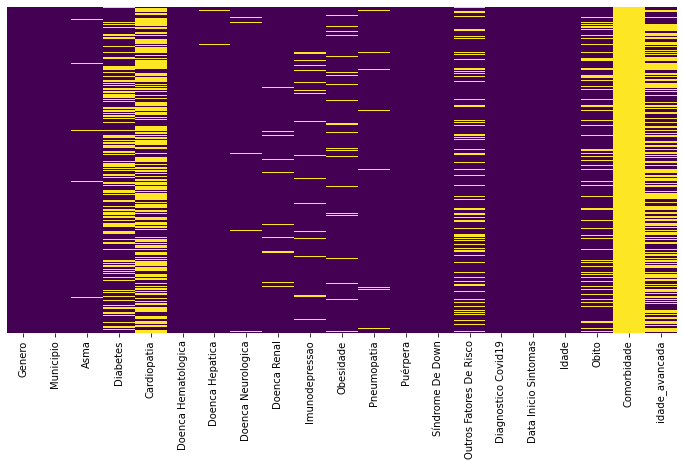

In [415]:
plt.figure(figsize=(12, 6))
sns.heatmap((df=='SIM') | (df==1), yticklabels=False, cbar=False, cmap='viridis')

In [416]:
df['Comorbidade'].value_counts()

SIM    554996
NÃO       445
Name: Comorbidade, dtype: int64

In [417]:
df[df['Comorbidade'] != 'SIM'].head()

,Genero,Municipio,Asma,Diabetes,Cardiopatia,Doenca Hematologica,Doenca Hepatica,Doenca Neurologica,Doenca Renal,Imunodepressao,...,Pneumopatia,Puérpera,Síndrome De Down,Outros Fatores De Risco,Diagnostico Covid19,Data Inicio Sintomas,Idade,Obito,Comorbidade,idade_avancada
1704,FEMININO,IGUAPE,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,...,NÃO,NÃO,NÃO,NÃO,CONFIRMADO,12/05/2021,70.0,1,NÃO,1
4823,FEMININO,SANTO ANDRE,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,...,NÃO,NÃO,NÃO,NÃO,CONFIRMADO,04/03/2021,52.0,0,NÃO,0
5010,FEMININO,SAO PAULO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,...,NÃO,NÃO,NÃO,NÃO,CONFIRMADO,24/04/2020,58.0,1,NÃO,0
7655,FEMININO,MONTE MOR,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,...,NÃO,NÃO,NÃO,NÃO,CONFIRMADO,13/06/2021,26.0,0,NÃO,0
9935,FEMININO,TABOAO DA SERRA,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,...,NÃO,NÃO,NÃO,NÃO,CONFIRMADO,20/01/2021,65.0,0,NÃO,1


# Comorbidades - Análise em conjunto

Uma análise em conjunto das comorbidades ajuda a visualizá-las em um mesmo contexto

In [418]:
df.columns

Index(['Genero', 'Municipio', 'Asma', 'Diabetes', 'Cardiopatia',
       'Doenca Hematologica', 'Doenca Hepatica', 'Doenca Neurologica',
       'Doenca Renal', 'Imunodepressao', 'Obesidade', 'Pneumopatia',
       'Puérpera', 'Síndrome De Down', 'Outros Fatores De Risco',
       'Diagnostico Covid19', 'Data Inicio Sintomas', 'Idade', 'Obito',
       'Comorbidade', 'idade_avancada'],
      dtype='object')

In [419]:
df.head()

,Genero,Municipio,Asma,Diabetes,Cardiopatia,Doenca Hematologica,Doenca Hepatica,Doenca Neurologica,Doenca Renal,Imunodepressao,...,Pneumopatia,Puérpera,Síndrome De Down,Outros Fatores De Risco,Diagnostico Covid19,Data Inicio Sintomas,Idade,Obito,Comorbidade,idade_avancada
0,FEMININO,SAO JOSE DOS CAMPOS,NÃO,SIM,SIM,NÃO,NÃO,NÃO,NÃO,NÃO,...,NÃO,NÃO,NÃO,NÃO,CONFIRMADO,17/05/2021,61.0,0,SIM,1
1,FEMININO,SAO JOSE DOS CAMPOS,NÃO,NÃO,SIM,NÃO,NÃO,NÃO,NÃO,NÃO,...,NÃO,NÃO,NÃO,NÃO,CONFIRMADO,05/05/2021,41.0,0,SIM,0
2,FEMININO,OURINHOS,NÃO,NÃO,SIM,NÃO,NÃO,NÃO,NÃO,NÃO,...,NÃO,NÃO,NÃO,NÃO,CONFIRMADO,26/10/2020,54.0,0,SIM,0
3,FEMININO,SAO PAULO,NÃO,SIM,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,...,NÃO,NÃO,NÃO,NÃO,CONFIRMADO,12/03/2021,53.0,0,SIM,0
4,FEMININO,CAMPINAS,NÃO,NÃO,SIM,NÃO,NÃO,NÃO,NÃO,NÃO,...,NÃO,NÃO,NÃO,NÃO,CONFIRMADO,17/07/2021,74.0,0,SIM,1


In [420]:
type(df.columns)

pandas.core.indexes.base.Index

In [421]:
df_comorbidades = df.columns.to_frame(index=False)

In [422]:
df_comorbidades.columns = ['Comorbidade']

In [423]:
df_comorbidades

,Comorbidade
0,Genero
1,Municipio
2,Asma
3,Diabetes
4,Cardiopatia
5,Doenca Hematologica
6,Doenca Hepatica
7,Doenca Neurologica
8,Doenca Renal
9,Imunodepressao


In [424]:
# exclusão das linhas que não são desejadas no gráfico para análise em conjunto
df_comorbidades.drop(df_comorbidades[df_comorbidades['Comorbidade'] == 'Genero'].index, inplace=True)
df_comorbidades.drop(df_comorbidades[df_comorbidades['Comorbidade'] == 'Municipio'].index, inplace=True)
df_comorbidades.drop(df_comorbidades[df_comorbidades['Comorbidade'] == 'Diagnostico Covid19'].index, inplace=True)
df_comorbidades.drop(df_comorbidades[df_comorbidades['Comorbidade'] == 'Data Inicio Sintomas'].index, inplace=True)
df_comorbidades.drop(df_comorbidades[df_comorbidades['Comorbidade'] == 'Idade'].index, inplace=True)
df_comorbidades.drop(df_comorbidades[df_comorbidades['Comorbidade'] == 'Obito'].index, inplace=True)

In [425]:
def Count_recuperados(comorbidade):
    tam = len(df[((df[comorbidade]=='SIM') | (df[comorbidade]== 0))&(df['Obito']==0)])
    return tam

In [426]:
df_comorbidades['Count_Recuperados'] = df_comorbidades['Comorbidade'].apply(Count_recuperados)

In [427]:
def Count_obitos(comorbidade):
    tam = len(df[((df[comorbidade]=='SIM') | (df[comorbidade]== 0))&(df['Obito']==1)])
    return tam

In [428]:
df_comorbidades['Count_Obitos'] = df_comorbidades['Comorbidade'].apply(Count_obitos)

In [429]:
df_comorbidades['Prop_Recuperados'] = df_comorbidades['Count_Recuperados'] / (df_comorbidades['Count_Recuperados'] + df_comorbidades['Count_Obitos'])

In [430]:
df_comorbidades['Prop_Obitos'] = df_comorbidades['Count_Obitos'] / (df_comorbidades['Count_Recuperados'] + df_comorbidades['Count_Obitos'])

<AxesSubplot:title={'center':'Análise das Comorbidades em conjunto - Contagem'}, xlabel='Comorbidade'>

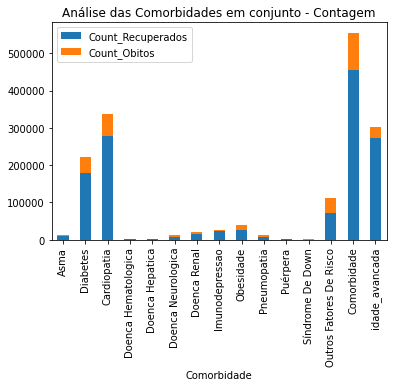

In [431]:
df_comorbidades.drop(['Prop_Recuperados', 'Prop_Obitos'], axis=1).plot.bar(x='Comorbidade', stacked=True, title='Análise das Comorbidades em conjunto - Contagem')

<AxesSubplot:title={'center':'Análise das Comorbidades em conjunto - Proporção'}, xlabel='Comorbidade'>

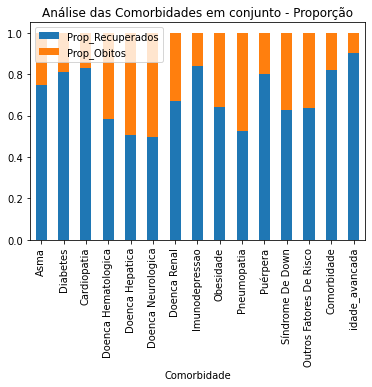

In [432]:
df_comorbidades.drop(['Count_Recuperados', 'Count_Obitos'], axis=1).plot.bar(x='Comorbidade', stacked=True, title='Análise das Comorbidades em conjunto - Proporção')

In [433]:
# exportar para colocar no gráfico
df_comorbidades.to_csv('df_comorbidades_graficos_barras.csv', sep = ';', index=False)

# Regras de Associação

In [434]:
df = pd.read_csv(r'dados_dummies_1.csv', sep = ';')

In [435]:
df.head()

,Genero_Masculino,Asma,Diabetes,Cardiopatia,Doenca Hematologica,Doenca Hepatica,Doenca Neurologica,Doenca Renal,Imunodepressao,Obesidade,Pneumopatia,Puérpera,Síndrome de Down,Outros Fatores De Risco,Comorbidade,idade_avancada,Obito
0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0


In [436]:
len(df)

555441

In [438]:
#Exclusão da coluna, pois não será mais útil
df.drop('Comorbidade', axis=1, inplace=True)
#df.drop('Obito', axis=1, inplace=True)

In [439]:
frequent_itemsets = apriori(df, min_support=0.1, use_colnames=True)

In [440]:
frequent_itemsets.sort_values(by='support', ascending=False)

,support,itemsets
2,0.605204,(Cardiopatia)
0,0.479329,(Genero_Masculino)
4,0.454369,(idade_avancada)
1,0.398815,(Diabetes)
12,0.296575,"(Cardiopatia, idade_avancada)"
7,0.285933,"(Genero_Masculino, Cardiopatia)"
9,0.217085,"(Genero_Masculino, idade_avancada)"
11,0.210762,"(Diabetes, idade_avancada)"
3,0.199908,(Outros Fatores De Risco)
10,0.190317,"(Diabetes, Cardiopatia)"


In [441]:
association_rules(frequent_itemsets, metric='confidence', min_threshold=0.4)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Diabetes),(Genero_Masculino),0.398815,0.479329,0.188074,0.471582,0.983839,-0.003089,0.985340
1,(Genero_Masculino),(Cardiopatia),0.479329,0.605204,0.285933,0.596528,0.985665,-0.004159,0.978497
2,(Cardiopatia),(Genero_Masculino),0.605204,0.479329,0.285933,0.472458,0.985665,-0.004159,0.986975
3,(Outros Fatores De Risco),(Genero_Masculino),0.199908,0.479329,0.103165,0.516062,1.076635,0.007343,1.075905
4,(Genero_Masculino),(idade_avancada),0.479329,0.454369,0.217085,0.452894,0.996754,-0.000707,0.997304
5,(idade_avancada),(Genero_Masculino),0.454369,0.479329,0.217085,0.477773,0.996754,-0.000707,0.997021
6,(Diabetes),(Cardiopatia),0.398815,0.605204,0.190317,0.477207,0.788507,-0.051047,0.755168
7,(Diabetes),(idade_avancada),0.398815,0.454369,0.210762,0.528472,1.163090,0.029553,1.157155
8,(idade_avancada),(Diabetes),0.454369,0.398815,0.210762,0.463857,1.163090,0.029553,1.121316
9,(Cardiopatia),(idade_avancada),0.605204,0.454369,0.296575,0.490042,1.078511,0.021589,1.069953


Lift menor ou igual a 1 significa que a regra não é muito relevante, então se altera os parâmetros para os seguintes:

In [442]:
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=1.1)

In [443]:
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Diabetes),(idade_avancada),0.398815,0.454369,0.210762,0.528472,1.163090,0.029553,1.157155
1,(idade_avancada),(Diabetes),0.454369,0.398815,0.210762,0.463857,1.163090,0.029553,1.121316
2,(Outros Fatores De Risco),(idade_avancada),0.199908,0.454369,0.113949,0.570008,1.254506,0.023117,1.268934
3,(idade_avancada),(Outros Fatores De Risco),0.454369,0.199908,0.113949,0.250786,1.254506,0.023117,1.067908
4,(Obito),(idade_avancada),0.178060,0.454369,0.123970,0.696225,1.532290,0.043065,1.796167
5,(idade_avancada),(Obito),0.454369,0.178060,0.123970,0.272840,1.532290,0.043065,1.130342
6,"(Diabetes, Cardiopatia)",(idade_avancada),0.190317,0.454369,0.120090,0.631000,1.388740,0.033616,1.478675
7,(idade_avancada),"(Diabetes, Cardiopatia)",0.454369,0.190317,0.120090,0.264301,1.388740,0.033616,1.100563


In [444]:
type(rules['antecedents'])

pandas.core.series.Series

In [445]:
rules[rules['consequents'] == {'Obito'}]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
5,(idade_avancada),(Obito),0.454369,0.17806,0.12397,0.27284,1.53229,0.043065,1.130342


Com a ideia de flexibilizar mais, visualizando regras mesmo que com suporte muito baixo

In [446]:
frequent_itemsets = apriori(df, min_support=0.01, use_colnames=True)

In [447]:
frequent_itemsets.sort_values(by='support', ascending=False)

,support,itemsets
3,0.605204,(Cardiopatia)
0,0.479329,(Genero_Masculino)
10,0.454369,(idade_avancada)
2,0.398815,(Diabetes)
34,0.296575,"(Cardiopatia, idade_avancada)"
...,...,...
81,0.010532,"(idade_avancada, Obito, Doenca Neurologica)"
50,0.010410,"(Genero_Masculino, Diabetes, Obesidade)"
77,0.010365,"(Cardiopatia, idade_avancada, Pneumopatia)"
30,0.010159,"(Imunodepressao, Cardiopatia)"


In [448]:
association_rules(frequent_itemsets, metric='confidence', min_threshold=0.4)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Diabetes),(Genero_Masculino),0.398815,0.479329,0.188074,0.471582,0.983839,-0.003089,0.985340
1,(Genero_Masculino),(Cardiopatia),0.479329,0.605204,0.285933,0.596528,0.985665,-0.004159,0.978497
2,(Cardiopatia),(Genero_Masculino),0.605204,0.479329,0.285933,0.472458,0.985665,-0.004159,0.986975
3,(Doenca Neurologica),(Genero_Masculino),0.024865,0.479329,0.012808,0.515097,1.074620,0.000889,1.073762
4,(Doenca Renal),(Genero_Masculino),0.039664,0.479329,0.021783,0.549181,1.145728,0.002771,1.154944
...,...,...,...,...,...,...,...,...,...
167,"(Obito, Outros Fatores De Risco, Diabetes, Car...",(idade_avancada),0.013497,0.454369,0.010835,0.802721,1.766673,0.004702,2.765786
168,"(Outros Fatores De Risco, Diabetes, idade_avan...",(Obito),0.021774,0.178060,0.010835,0.497602,2.794571,0.006958,1.636033
169,"(Outros Fatores De Risco, Diabetes, idade_avan...",(Cardiopatia),0.020270,0.605204,0.010835,0.534506,0.883183,-0.001433,0.848123
170,"(Outros Fatores De Risco, Cardiopatia, idade_a...",(Diabetes),0.023232,0.398815,0.010835,0.466367,1.169383,0.001569,1.126590


Lift menor ou igual a 1 significa que a regra não é muito relevante, então se altera os parâmetros para os seguintes:

In [449]:
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=1.1)

In [450]:
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Doenca Renal),(Genero_Masculino),0.039664,0.479329,0.021783,0.549181,1.145728,0.002771,1.154944
1,(Genero_Masculino),(Doenca Renal),0.479329,0.039664,0.021783,0.045444,1.145728,0.002771,1.006055
2,(Genero_Masculino),(Pneumopatia),0.479329,0.023615,0.013143,0.027419,1.161060,0.001823,1.003911
3,(Pneumopatia),(Genero_Masculino),0.023615,0.479329,0.013143,0.556530,1.161060,0.001823,1.174083
4,(Genero_Masculino),(Obito),0.479329,0.178060,0.099094,0.206735,1.161041,0.013745,1.036148
...,...,...,...,...,...,...,...,...,...
391,"(idade_avancada, Obito)","(Outros Fatores De Risco, Diabetes, Cardiopatia)",0.123970,0.029251,0.010835,0.087397,2.987876,0.007208,1.063715
392,(Outros Fatores De Risco),"(Obito, Diabetes, idade_avancada, Cardiopatia)",0.199908,0.037293,0.010835,0.054198,1.453311,0.003379,1.017874
393,(Diabetes),"(Outros Fatores De Risco, Cardiopatia, idade_a...",0.398815,0.023232,0.010835,0.027167,1.169383,0.001569,1.004045
394,(Obito),"(Outros Fatores De Risco, Diabetes, idade_avan...",0.178060,0.021774,0.010835,0.060848,2.794571,0.006958,1.041606


In [451]:
type(rules['antecedents'])

pandas.core.series.Series

In [452]:
consequencia_obito = rules[rules['consequents'] == {'Obito'}]

In [453]:
consequencia_obito = consequencia_obito.sort_values(by='confidence', ascending=False)

In [454]:
consequencia_obito.reset_index(drop=True, inplace=True)

Todas as regras exibidas a seguir contam com um Suporte de pelo menos 1% para os itemsets. Os valores para Confiança podem até não ser altos, mas é preciso levar em consideração que a maior parte das pessoas que contraem corona vírus conseguem se recuperar. 

In [455]:
pd.set_option('display.max_colwidth', None)
consequencia_obito[['antecedents', 'consequents', 'support', 'confidence']]

,antecedents,consequents,support,confidence
0,"(idade_avancada, Doenca Neurologica)",(Obito),0.010532,0.561906
1,"(Genero_Masculino, Outros Fatores De Risco, Cardiopatia, idade_avancada)",(Obito),0.012642,0.515982
2,"(Genero_Masculino, Outros Fatores De Risco, Diabetes, idade_avancada)",(Obito),0.010743,0.506666
3,(Doenca Neurologica),(Obito),0.012518,0.503439
4,"(Outros Fatores De Risco, Diabetes, idade_avancada, Cardiopatia)",(Obito),0.010835,0.497602
5,"(Obesidade, idade_avancada)",(Obito),0.011267,0.493923
6,"(Genero_Masculino, idade_avancada, Outros Fatores De Risco)",(Obito),0.028214,0.487950
7,"(Outros Fatores De Risco, Cardiopatia, idade_avancada)",(Obito),0.023232,0.481457
8,(Pneumopatia),(Obito),0.011193,0.473965
9,"(Outros Fatores De Risco, Diabetes, idade_avancada)",(Obito),0.020270,0.471858


In [456]:
print("Foram geradas então {0} regras, vamos selecionar as que têm confiança acima da média {1}".format(len(consequencia_obito), consequencia_obito['confidence'].mean()))

Foram geradas então 36 regras, vamos selecionar as que têm confiança acima da média 0.3845370589786582


In [457]:
df = consequencia_obito[consequencia_obito['confidence'] > consequencia_obito['confidence'].mean()]

In [458]:
df

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,"(idade_avancada, Doenca Neurologica)",(Obito),0.018744,0.17806,0.010532,0.561906,3.155704,0.007195,1.876171
1,"(Genero_Masculino, Outros Fatores De Risco, Cardiopatia, idade_avancada)",(Obito),0.024501,0.17806,0.012642,0.515982,2.897794,0.008280,1.698160
2,"(Genero_Masculino, Outros Fatores De Risco, Diabetes, idade_avancada)",(Obito),0.021203,0.17806,0.010743,0.506666,2.845471,0.006967,1.666090
3,(Doenca Neurologica),(Obito),0.024865,0.17806,0.012518,0.503439,2.827353,0.008091,1.655265
4,"(Outros Fatores De Risco, Diabetes, idade_avancada, Cardiopatia)",(Obito),0.021774,0.17806,0.010835,0.497602,2.794571,0.006958,1.636033
5,"(Obesidade, idade_avancada)",(Obito),0.022811,0.17806,0.011267,0.493923,2.773906,0.007205,1.624138
6,"(Genero_Masculino, idade_avancada, Outros Fatores De Risco)",(Obito),0.057821,0.17806,0.028214,0.487950,2.740363,0.017918,1.605194
7,"(Outros Fatores De Risco, Cardiopatia, idade_avancada)",(Obito),0.048254,0.17806,0.023232,0.481457,2.703896,0.014640,1.585093
8,(Pneumopatia),(Obito),0.023615,0.17806,0.011193,0.473965,2.661823,0.006988,1.562519
9,"(Outros Fatores De Risco, Diabetes, idade_avancada)",(Obito),0.042959,0.17806,0.020270,0.471858,2.649989,0.012621,1.556285


In [459]:
df = df[['antecedents', 'consequents', 'support', 'confidence']]

In [460]:
df.to_csv(r'18_regras.csv', sep = ';', index=False)

<AxesSubplot:ylabel='confidence'>

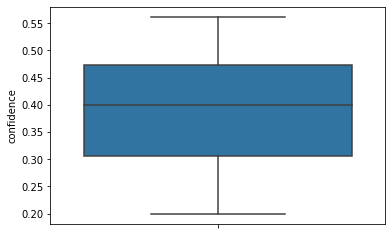

In [461]:
sns.boxplot(y='confidence', data=consequencia_obito)

# Regressão Logística

In [462]:
def RegressaoLogistica(num_tentativa):

    global X_train, X_test, y_train, y_test
    arquivo = ""
    if num_tentativa == 1:
        arquivo = 'dados_dummies_1.csv'
    elif num_tentativa == 2:
        arquivo = 'dados_dummies_2.csv'
    elif num_tentativa == 3:
        arquivo = 'dados_dummies_3.csv'
    elif num_tentativa in [4, 6, 7]:
        arquivo = 'dados_dummies_4.csv'
    elif num_tentativa == 5:
        X_train = (pd.read_csv('dados_dummies_5_train.csv', sep = ';')).drop('Obito', axis=1)
        X_test  = (pd.read_csv('dados_dummies_5_test.csv', sep = ';')).drop('Obito', axis=1)
        y_train = pd.read_csv('dados_dummies_5_train.csv', sep = ';')['Obito']
        y_test  = pd.read_csv('dados_dummies_5_test.csv', sep = ';')['Obito']

        print('\nQuantidade de registros no arquivo: {}'.format(len(X_train) + len(X_test)))
    
        print('\nAs colunas no dataframe são: \n')
        print(X_train.columns)
        
        
    if num_tentativa != 5:
        df = pd.read_csv(arquivo, sep = ';')
    
        print('\nQuantidade de registros no arquivo: {}'.format(len(df)))
    
        print('\nAs colunas no dataframe são: \n')
        print(df.columns)
    
        X_train, X_test, y_train, y_test = train_test_split(df.drop('Obito', axis=1), df['Obito'], test_size=0.3)
        
        if num_tentativa == 6:
            print('\nQuantidades de recuperados e óbitos na amostra para treino antes do smote:')
            print(y_train.to_frame().Obito.value_counts())
            
            sm = SMOTE(random_state=42) # oversampling SMOTE
            X_train, y_train = sm.fit_resample(X_train, y_train)
            
            print('\nQuantidades de recuperados e óbitos na amostra para treino depois do smote:')
            print(y_train.to_frame().Obito.value_counts())
                       
    print("\nnúmero de amostras para treino: ", len(X_train))
    print("número de amostras para teste: ", len(X_test))
    
    logmodel = LogisticRegression() 
    
    if num_tentativa != 7:
        #logmodel = LogisticRegression()
        logmodel.fit(X_train, y_train)    
        predictions = logmodel.predict(X_test)
        
    else:            
        #logmodel = LogisticRegression(class_weight = {0 : 4, 1: 1}) 
        #Rodei diversas vezes, a precisão da classe 1 foi de 61 à 74%, variando bastante

        #logmodel = LogisticRegression(max_iter = 200)
        #não trouxe melhoria
        
        params = {'max_iter' : [100, 200, 500], 'class_weight' : [{0 : 2, 1: 1}, {0 : 1, 1: 2}, {0 : 1, 1: 1}]}

        grid = GridSearchCV(logmodel, param_grid = params)

        predictions = grid.fit(X_train, y_train).predict(X_test)

        print('\nOs melhores parâmetros encontrados pelo GridSearch:\n')

        print(grid.best_params_)
   
    print('\nRelatório de Classificação:\n')
    print(classification_report(y_test, predictions))
    
    print('\nMatriz de Confusão do Modelo:\n')
    print(confusion_matrix(y_test, predictions))
    cf_matrix = confusion_matrix(y_test, predictions)
    make_confusion_matrix(cf_matrix)
    
    

## Tentativa 1


Quantidade de registros no arquivo: 555441

As colunas no dataframe são: 

Index(['Genero_Masculino', 'Asma', 'Diabetes', 'Cardiopatia',
       'Doenca Hematologica', 'Doenca Hepatica', 'Doenca Neurologica',
       'Doenca Renal', 'Imunodepressao', 'Obesidade', 'Pneumopatia',
       'Puérpera', 'Síndrome de Down', 'Outros Fatores De Risco',
       'Comorbidade', 'idade_avancada', 'Obito'],
      dtype='object')

número de amostras para treino:  388808
número de amostras para teste:  166633

Relatório de Classificação:

              precision    recall  f1-score   support

           0       0.84      0.98      0.90    136967
           1       0.54      0.12      0.19     29666

    accuracy                           0.83    166633
   macro avg       0.69      0.55      0.55    166633
weighted avg       0.78      0.83      0.78    166633


Matriz de Confusão do Modelo:

[[134054   2913]
 [ 26181   3485]]


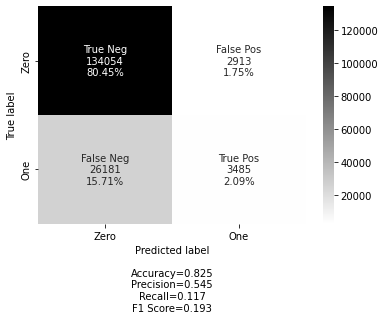

In [463]:
RegressaoLogistica(1)

## Tentativa 2, com faixas etárias 


Quantidade de registros no arquivo: 555441

As colunas no dataframe são: 

Index(['Genero_Masculino', 'Asma', 'Diabetes', 'Cardiopatia',
       'Doenca Hematologica', 'Doenca Hepatica', 'Doenca Neurologica',
       'Doenca Renal', 'Imunodepressao', 'Obesidade', 'Pneumopatia',
       'Puérpera', 'Síndrome de Down', 'Outros Fatores De Risco',
       'Comorbidade', 'Obito', 'até 22 anos', 'de 23 a 29 anos',
       'de 30 a 39 anos', 'de 40 a 49 anos', 'de 50 a 59 anos',
       'de 60 a 69 anos', 'de 70 a 79 anos'],
      dtype='object')

número de amostras para treino:  388808
número de amostras para teste:  166633

Relatório de Classificação:

              precision    recall  f1-score   support

           0       0.84      0.97      0.90    136639
           1       0.56      0.18      0.27     29994

    accuracy                           0.83    166633
   macro avg       0.70      0.57      0.59    166633
weighted avg       0.79      0.83      0.79    166633


Matriz de Confusão do

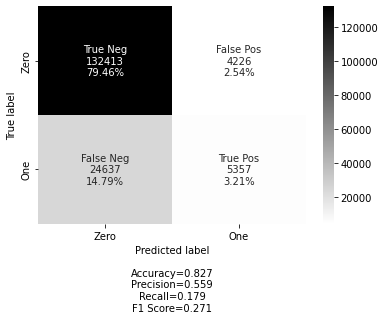

In [464]:
RegressaoLogistica(2)

## tentativa 3, com seleção de período mais específico


Quantidade de registros no arquivo: 163820

As colunas no dataframe são: 

Index(['Genero_Masculino', 'Asma', 'Diabetes', 'Cardiopatia',
       'Doenca Hematologica', 'Doenca Hepatica', 'Doenca Neurologica',
       'Doenca Renal', 'Imunodepressao', 'Obesidade', 'Pneumopatia',
       'Puérpera', 'Síndrome de Down', 'Outros Fatores De Risco',
       'Comorbidade', 'Obito', 'até 22 anos', 'de 23 a 29 anos',
       'de 30 a 39 anos', 'de 40 a 49 anos', 'de 50 a 59 anos',
       'de 60 a 69 anos', 'de 70 a 79 anos'],
      dtype='object')

número de amostras para treino:  114674
número de amostras para teste:  49146

Relatório de Classificação:

              precision    recall  f1-score   support

           0       0.88      0.98      0.93     42377
           1       0.56      0.18      0.27      6769

    accuracy                           0.87     49146
   macro avg       0.72      0.58      0.60     49146
weighted avg       0.84      0.87      0.84     49146


Matriz de Confusão do 

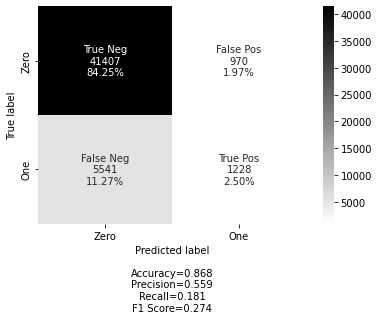

In [465]:
RegressaoLogistica(3)

## Tentativa 4, quantidades de comorbidades


Quantidade de registros no arquivo: 163820

As colunas no dataframe são: 

Index(['Genero_Masculino', 'Asma', 'Diabetes', 'Cardiopatia',
       'Doenca Hematologica', 'Doenca Hepatica', 'Doenca Neurologica',
       'Doenca Renal', 'Imunodepressao', 'Obesidade', 'Pneumopatia',
       'Puérpera', 'Síndrome de Down', 'Outros Fatores De Risco', 'Obito',
       'até 22 anos', 'de 23 a 29 anos', 'de 30 a 39 anos', 'de 40 a 49 anos',
       'de 50 a 59 anos', 'de 60 a 69 anos', 'de 70 a 79 anos',
       '2_comorbidades', '3_comorbidades', '4_ou_mais'],
      dtype='object')

número de amostras para treino:  114674
número de amostras para teste:  49146

Relatório de Classificação:

              precision    recall  f1-score   support

           0       0.88      0.98      0.93     42403
           1       0.55      0.19      0.28      6743

    accuracy                           0.87     49146
   macro avg       0.72      0.58      0.60     49146
weighted avg       0.84      0.87      0.84 

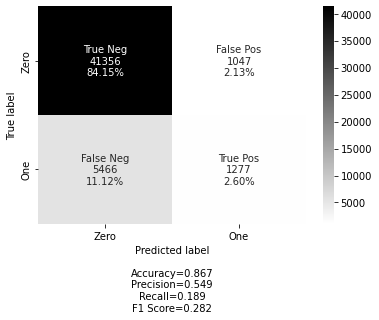

In [466]:
RegressaoLogistica(4)

## Tentativa 5, balanceamento dos dados - undersampling


Quantidade de registros no arquivo: 163820

As colunas no dataframe são: 

Index(['Genero_Masculino', 'Asma', 'Diabetes', 'Cardiopatia',
       'Doenca Hematologica', 'Doenca Hepatica', 'Doenca Neurologica',
       'Doenca Renal', 'Imunodepressao', 'Obesidade', 'Pneumopatia',
       'Puérpera', 'Síndrome de Down', 'Outros Fatores De Risco',
       'até 22 anos', 'de 23 a 29 anos', 'de 30 a 39 anos', 'de 40 a 49 anos',
       'de 50 a 59 anos', 'de 60 a 69 anos', 'de 70 a 79 anos',
       '2_comorbidades', '3_comorbidades', '4_ou_mais'],
      dtype='object')

número de amostras para treino:  31456
número de amostras para teste:  132364

Relatório de Classificação:

              precision    recall  f1-score   support

           0       0.98      0.75      0.85    125622
           1       0.14      0.76      0.24      6742

    accuracy                           0.75    132364
   macro avg       0.56      0.75      0.54    132364
weighted avg       0.94      0.75      0.82    132364

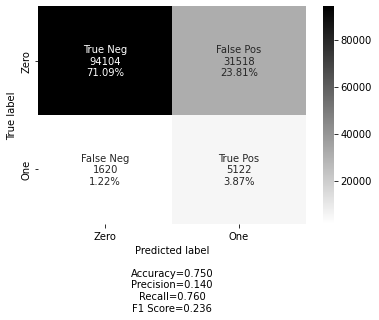

In [467]:
RegressaoLogistica(5)

Infelizmente um comportamento inesperado ocorreu: aumentou a quantidade de Falsos Positivos

## Tentativa 6, balanceamento dos dados - oversampling SMOTE


Quantidade de registros no arquivo: 163820

As colunas no dataframe são: 

Index(['Genero_Masculino', 'Asma', 'Diabetes', 'Cardiopatia',
       'Doenca Hematologica', 'Doenca Hepatica', 'Doenca Neurologica',
       'Doenca Renal', 'Imunodepressao', 'Obesidade', 'Pneumopatia',
       'Puérpera', 'Síndrome de Down', 'Outros Fatores De Risco', 'Obito',
       'até 22 anos', 'de 23 a 29 anos', 'de 30 a 39 anos', 'de 40 a 49 anos',
       'de 50 a 59 anos', 'de 60 a 69 anos', 'de 70 a 79 anos',
       '2_comorbidades', '3_comorbidades', '4_ou_mais'],
      dtype='object')

Quantidades de recuperados e óbitos na amostra para treino antes do smote:
0    98983
1    15691
Name: Obito, dtype: int64

Quantidades de recuperados e óbitos na amostra para treino depois do smote:
0    98983
1    98983
Name: Obito, dtype: int64

número de amostras para treino:  197966
número de amostras para teste:  49146


C:\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Relatório de Classificação:

              precision    recall  f1-score   support

           0       0.95      0.75      0.84     42367
           1       0.33      0.75      0.46      6779

    accuracy                           0.75     49146
   macro avg       0.64      0.75      0.65     49146
weighted avg       0.86      0.75      0.79     49146


Matriz de Confusão do Modelo:

[[31960 10407]
 [ 1693  5086]]


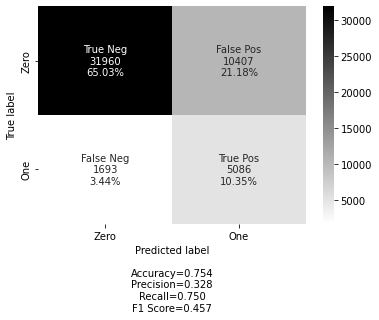

In [468]:
RegressaoLogistica(6)

## Tentativa 7, hiperparâmetros


Quantidade de registros no arquivo: 163820

As colunas no dataframe são: 

Index(['Genero_Masculino', 'Asma', 'Diabetes', 'Cardiopatia',
       'Doenca Hematologica', 'Doenca Hepatica', 'Doenca Neurologica',
       'Doenca Renal', 'Imunodepressao', 'Obesidade', 'Pneumopatia',
       'Puérpera', 'Síndrome de Down', 'Outros Fatores De Risco', 'Obito',
       'até 22 anos', 'de 23 a 29 anos', 'de 30 a 39 anos', 'de 40 a 49 anos',
       'de 50 a 59 anos', 'de 60 a 69 anos', 'de 70 a 79 anos',
       '2_comorbidades', '3_comorbidades', '4_ou_mais'],
      dtype='object')

número de amostras para treino:  114674
número de amostras para teste:  49146

Os melhores parâmetros encontrados pelo GridSearch:

{'class_weight': {0: 1, 1: 1}, 'max_iter': 100}

Relatório de Classificação:

              precision    recall  f1-score   support

           0       0.88      0.98      0.93     42422
           1       0.55      0.18      0.27      6724

    accuracy                           0.87     49

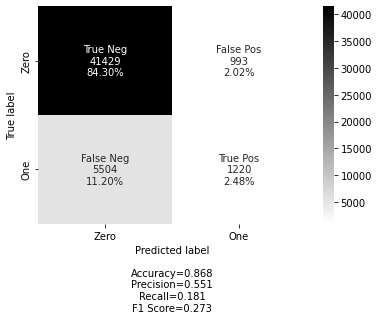

In [471]:
RegressaoLogistica(7)

# Árvores de Decisão

In [472]:
def ArvoreDeDecisao(num_tentativa):
    global X_train, X_test, y_train, y_test
    arquivo = ""
    if num_tentativa == 1:
        arquivo = 'dados_dummies_1.csv'
    elif num_tentativa == 2:
        arquivo = 'dados_dummies_2.csv'
    elif num_tentativa == 3:
        arquivo = 'dados_dummies_3.csv'
    elif num_tentativa in [4, 6, 7]:
        arquivo = 'dados_dummies_4.csv'
    elif num_tentativa == 5:
        X_train = (pd.read_csv('dados_dummies_5_train.csv', sep = ';')).drop('Obito', axis=1)
        X_test  = (pd.read_csv('dados_dummies_5_test.csv', sep = ';')).drop('Obito', axis=1)
        y_train = pd.read_csv('dados_dummies_5_train.csv', sep = ';')['Obito']
        y_test  = pd.read_csv('dados_dummies_5_test.csv', sep = ';')['Obito']

        print('\nQuantidade de registros no arquivo: {}'.format(len(X_train) + len(X_test)))
    
        print('\nAs colunas no dataframe são: \n')
        print(X_train.columns)
        
        
    if num_tentativa != 5:
        df = pd.read_csv(arquivo, sep = ';')
    
        print('\nQuantidade de registros no arquivo: {}'.format(len(df)))
    
        print('\nAs colunas no dataframe são: \n')
        print(df.columns)
    
        X_train, X_test, y_train, y_test = train_test_split(df.drop('Obito', axis=1), df['Obito'], test_size=0.3, random_state=0)
        
        
        if num_tentativa == 6:
            print('\nQuantidades de recuperados e óbitos na amostra para treino antes do smote:')
            print(y_train.to_frame().Obito.value_counts())

            sm = SMOTE(random_state=42) # oversampling SMOTE
            X_train, y_train = sm.fit_resample(X_train, y_train)

            print('\nQuantidades de recuperados e óbitos na amostra para treino depois do smote:')
            print(y_train.to_frame().Obito.value_counts())

    print("\nnúmero de amostras para treino: ", len(X_train))
    print("número de amostras para teste: ", len(X_test))
    
    decision_tree = DecisionTreeClassifier(random_state=0)
    
    if num_tentativa !=7:
        
        decision_tree.fit(X_train, y_train)
        y_pred = decision_tree.predict(X_test)
        
    else:        
        params = {'criterion':('gini', 'entropy'), 'min_samples_leaf':[1, 2, 3], 'max_depth': np.arange(3, 15)}

        grid = GridSearchCV(decision_tree, param_grid = params)

        y_pred = grid.fit(X_train, y_train).predict(X_test)

        print('\nOs melhores parâmetros encontrados pelo GridSearch:\n')

        print(grid.best_params_)
    
    print('\nRelatório de Classificação:\n')
    print(classification_report(y_test, y_pred))
    
    print('\nMatriz de Confusão do Modelo:\n')
    print(confusion_matrix(y_test, y_pred))
    cf_matrix = confusion_matrix(y_test, y_pred)
    make_confusion_matrix(cf_matrix)

## Tentativa 1


Quantidade de registros no arquivo: 555441

As colunas no dataframe são: 

Index(['Genero_Masculino', 'Asma', 'Diabetes', 'Cardiopatia',
       'Doenca Hematologica', 'Doenca Hepatica', 'Doenca Neurologica',
       'Doenca Renal', 'Imunodepressao', 'Obesidade', 'Pneumopatia',
       'Puérpera', 'Síndrome de Down', 'Outros Fatores De Risco',
       'Comorbidade', 'idade_avancada', 'Obito'],
      dtype='object')

número de amostras para treino:  388808
número de amostras para teste:  166633

Relatório de Classificação:

              precision    recall  f1-score   support

           0       0.84      0.98      0.90    137025
           1       0.57      0.13      0.21     29608

    accuracy                           0.83    166633
   macro avg       0.70      0.55      0.56    166633
weighted avg       0.79      0.83      0.78    166633


Matriz de Confusão do Modelo:

[[134097   2928]
 [ 25751   3857]]


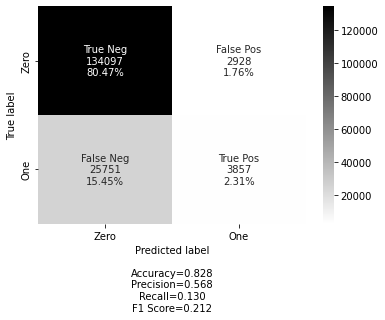

In [473]:
ArvoreDeDecisao(1)

## Tentativa 2, com faixas etárias 


Quantidade de registros no arquivo: 555441

As colunas no dataframe são: 

Index(['Genero_Masculino', 'Asma', 'Diabetes', 'Cardiopatia',
       'Doenca Hematologica', 'Doenca Hepatica', 'Doenca Neurologica',
       'Doenca Renal', 'Imunodepressao', 'Obesidade', 'Pneumopatia',
       'Puérpera', 'Síndrome de Down', 'Outros Fatores De Risco',
       'Comorbidade', 'Obito', 'até 22 anos', 'de 23 a 29 anos',
       'de 30 a 39 anos', 'de 40 a 49 anos', 'de 50 a 59 anos',
       'de 60 a 69 anos', 'de 70 a 79 anos'],
      dtype='object')

número de amostras para treino:  388808
número de amostras para teste:  166633

Relatório de Classificação:

              precision    recall  f1-score   support

           0       0.84      0.97      0.90    137025
           1       0.56      0.18      0.27     29608

    accuracy                           0.83    166633
   macro avg       0.70      0.57      0.59    166633
weighted avg       0.79      0.83      0.79    166633


Matriz de Confusão do

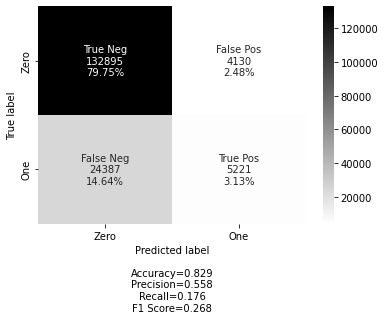

In [474]:
ArvoreDeDecisao(2)

## tentativa 3, com seleção de período mais específico


Quantidade de registros no arquivo: 163820

As colunas no dataframe são: 

Index(['Genero_Masculino', 'Asma', 'Diabetes', 'Cardiopatia',
       'Doenca Hematologica', 'Doenca Hepatica', 'Doenca Neurologica',
       'Doenca Renal', 'Imunodepressao', 'Obesidade', 'Pneumopatia',
       'Puérpera', 'Síndrome de Down', 'Outros Fatores De Risco',
       'Comorbidade', 'Obito', 'até 22 anos', 'de 23 a 29 anos',
       'de 30 a 39 anos', 'de 40 a 49 anos', 'de 50 a 59 anos',
       'de 60 a 69 anos', 'de 70 a 79 anos'],
      dtype='object')

número de amostras para treino:  114674
número de amostras para teste:  49146

Relatório de Classificação:

              precision    recall  f1-score   support

           0       0.88      0.98      0.93     42460
           1       0.54      0.18      0.27      6686

    accuracy                           0.87     49146
   macro avg       0.71      0.58      0.60     49146
weighted avg       0.84      0.87      0.84     49146


Matriz de Confusão do 

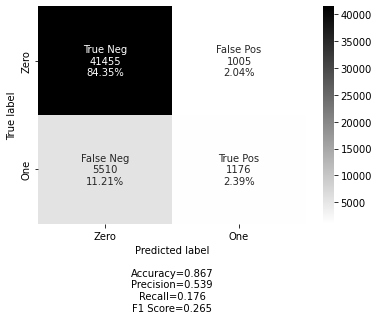

In [475]:
ArvoreDeDecisao(3)

## Tentativa 4, quantidade de comorbidades


Quantidade de registros no arquivo: 163820

As colunas no dataframe são: 

Index(['Genero_Masculino', 'Asma', 'Diabetes', 'Cardiopatia',
       'Doenca Hematologica', 'Doenca Hepatica', 'Doenca Neurologica',
       'Doenca Renal', 'Imunodepressao', 'Obesidade', 'Pneumopatia',
       'Puérpera', 'Síndrome de Down', 'Outros Fatores De Risco', 'Obito',
       'até 22 anos', 'de 23 a 29 anos', 'de 30 a 39 anos', 'de 40 a 49 anos',
       'de 50 a 59 anos', 'de 60 a 69 anos', 'de 70 a 79 anos',
       '2_comorbidades', '3_comorbidades', '4_ou_mais'],
      dtype='object')

número de amostras para treino:  114674
número de amostras para teste:  49146

Relatório de Classificação:

              precision    recall  f1-score   support

           0       0.88      0.98      0.93     42460
           1       0.54      0.18      0.26      6686

    accuracy                           0.87     49146
   macro avg       0.71      0.58      0.60     49146
weighted avg       0.84      0.87      0.84 

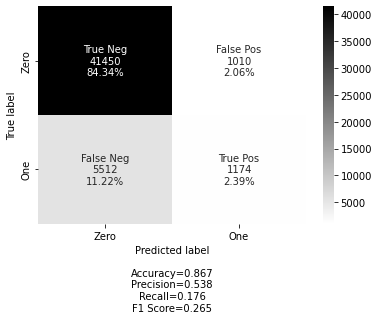

In [476]:
ArvoreDeDecisao(4)

## Tentativa 5,  com balanceamento dos dados - undersampling


Quantidade de registros no arquivo: 163820

As colunas no dataframe são: 

Index(['Genero_Masculino', 'Asma', 'Diabetes', 'Cardiopatia',
       'Doenca Hematologica', 'Doenca Hepatica', 'Doenca Neurologica',
       'Doenca Renal', 'Imunodepressao', 'Obesidade', 'Pneumopatia',
       'Puérpera', 'Síndrome de Down', 'Outros Fatores De Risco',
       'até 22 anos', 'de 23 a 29 anos', 'de 30 a 39 anos', 'de 40 a 49 anos',
       'de 50 a 59 anos', 'de 60 a 69 anos', 'de 70 a 79 anos',
       '2_comorbidades', '3_comorbidades', '4_ou_mais'],
      dtype='object')

número de amostras para treino:  31456
número de amostras para teste:  132364

Relatório de Classificação:

              precision    recall  f1-score   support

           0       0.98      0.72      0.83    125622
           1       0.13      0.78      0.22      6742

    accuracy                           0.73    132364
   macro avg       0.56      0.75      0.53    132364
weighted avg       0.94      0.73      0.80    132364

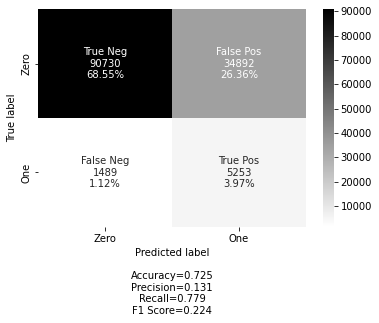

In [477]:
ArvoreDeDecisao(5)

## Tentativa 6, com balanceamento dos dados - oversampling SMOTE


Quantidade de registros no arquivo: 163820

As colunas no dataframe são: 

Index(['Genero_Masculino', 'Asma', 'Diabetes', 'Cardiopatia',
       'Doenca Hematologica', 'Doenca Hepatica', 'Doenca Neurologica',
       'Doenca Renal', 'Imunodepressao', 'Obesidade', 'Pneumopatia',
       'Puérpera', 'Síndrome de Down', 'Outros Fatores De Risco', 'Obito',
       'até 22 anos', 'de 23 a 29 anos', 'de 30 a 39 anos', 'de 40 a 49 anos',
       'de 50 a 59 anos', 'de 60 a 69 anos', 'de 70 a 79 anos',
       '2_comorbidades', '3_comorbidades', '4_ou_mais'],
      dtype='object')

Quantidades de recuperados e óbitos na amostra para treino antes do smote:
0    98890
1    15784
Name: Obito, dtype: int64

Quantidades de recuperados e óbitos na amostra para treino depois do smote:
0    98890
1    98890
Name: Obito, dtype: int64

número de amostras para treino:  197780
número de amostras para teste:  49146

Relatório de Classificação:

              precision    recall  f1-score   support

           0

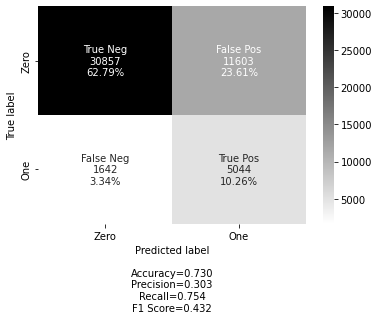

In [478]:
ArvoreDeDecisao(6)

## Tentativa 7, hiperparâmetros


Quantidade de registros no arquivo: 163820

As colunas no dataframe são: 

Index(['Genero_Masculino', 'Asma', 'Diabetes', 'Cardiopatia',
       'Doenca Hematologica', 'Doenca Hepatica', 'Doenca Neurologica',
       'Doenca Renal', 'Imunodepressao', 'Obesidade', 'Pneumopatia',
       'Puérpera', 'Síndrome de Down', 'Outros Fatores De Risco', 'Obito',
       'até 22 anos', 'de 23 a 29 anos', 'de 30 a 39 anos', 'de 40 a 49 anos',
       'de 50 a 59 anos', 'de 60 a 69 anos', 'de 70 a 79 anos',
       '2_comorbidades', '3_comorbidades', '4_ou_mais'],
      dtype='object')

número de amostras para treino:  114674
número de amostras para teste:  49146

Os melhores parâmetros encontrados pelo GridSearch:

{'criterion': 'gini', 'max_depth': 11, 'min_samples_leaf': 2}

Relatório de Classificação:

              precision    recall  f1-score   support

           0       0.88      0.98      0.93     42460
           1       0.56      0.15      0.23      6686

    accuracy                        

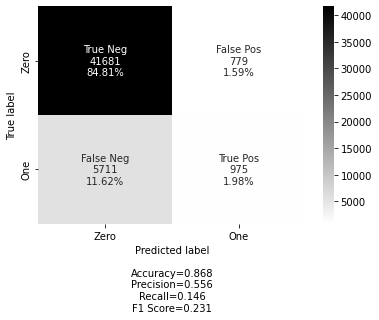

In [479]:
ArvoreDeDecisao(7)

# Florestas Aleatórias

In [480]:
def FlorestasAleatorias(num_tentativa):
    global X_train, X_test, y_train, y_test
    arquivo = ""
    if num_tentativa == 1:
        arquivo = 'dados_dummies_1.csv'
    elif num_tentativa == 2:
        arquivo = 'dados_dummies_2.csv'
    elif num_tentativa == 3:
        arquivo = 'dados_dummies_3.csv'
    elif num_tentativa in [4, 6]:
        arquivo = 'dados_dummies_4.csv'
    elif num_tentativa == 5:
        X_train = (pd.read_csv('dados_dummies_5_train.csv', sep = ';')).drop('Obito', axis=1)
        X_test  = (pd.read_csv('dados_dummies_5_test.csv', sep = ';')).drop('Obito', axis=1)
        y_train = pd.read_csv('dados_dummies_5_train.csv', sep = ';')['Obito']
        y_test  = pd.read_csv('dados_dummies_5_test.csv', sep = ';')['Obito']

        print('\nQuantidade de registros no arquivo: {}'.format(len(X_train) + len(X_test)))
    
        print('\nAs colunas no dataframe são: \n')
        print(X_train.columns)
        
    if num_tentativa != 5:    
        df = pd.read_csv(arquivo, sep = ';')

        print('\nQuantidade de registros no arquivo: {}'.format(len(df)))

        print('\nAs colunas no dataframe são: \n')
        print(df.columns)

        X = df.drop('Obito', axis = 1)
        y = df['Obito']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)
    
        if num_tentativa == 6:
            print('\nQuantidades de recuperados e óbitos na amostra para treino antes do smote:')
            print(y_train.to_frame().Obito.value_counts())

            sm = SMOTE(random_state=42) # oversampling SMOTE
            X_train, y_train = sm.fit_resample(X_train, y_train)

            print('\nQuantidades de recuperados e óbitos na amostra para treino depois do smote:')
            print(y_train.to_frame().Obito.value_counts())

    
    print("\nnúmero de amostras para treino: ", len(X_train))
    print("número de amostras para teste: ", len(y_test))
    
    rfc = RandomForestClassifier(n_estimators = 200, random_state=0)
    
    rfc.fit(X_train, y_train)
    
    rfc_pred = rfc.predict(X_test)
    
    print('\nRelatório de Classificação:\n')
    print(classification_report(y_test, rfc_pred))
    
    print('\nMatriz de Confusão do Modelo:\n')
    print(confusion_matrix(y_test, rfc_pred))
    cf_matrix = confusion_matrix(y_test, rfc_pred)
    make_confusion_matrix(cf_matrix)

## Tentativa 1


Quantidade de registros no arquivo: 555441

As colunas no dataframe são: 

Index(['Genero_Masculino', 'Asma', 'Diabetes', 'Cardiopatia',
       'Doenca Hematologica', 'Doenca Hepatica', 'Doenca Neurologica',
       'Doenca Renal', 'Imunodepressao', 'Obesidade', 'Pneumopatia',
       'Puérpera', 'Síndrome de Down', 'Outros Fatores De Risco',
       'Comorbidade', 'idade_avancada', 'Obito'],
      dtype='object')

número de amostras para treino:  388808
número de amostras para teste:  166633

Relatório de Classificação:

              precision    recall  f1-score   support

           0       0.84      0.98      0.90    137025
           1       0.57      0.13      0.22     29608

    accuracy                           0.83    166633
   macro avg       0.70      0.56      0.56    166633
weighted avg       0.79      0.83      0.78    166633


Matriz de Confusão do Modelo:

[[133984   3041]
 [ 25648   3960]]


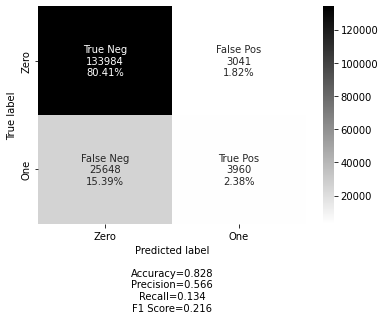

In [481]:
FlorestasAleatorias(1)

## Tentativa 2, com faixas etárias 


Quantidade de registros no arquivo: 555441

As colunas no dataframe são: 

Index(['Genero_Masculino', 'Asma', 'Diabetes', 'Cardiopatia',
       'Doenca Hematologica', 'Doenca Hepatica', 'Doenca Neurologica',
       'Doenca Renal', 'Imunodepressao', 'Obesidade', 'Pneumopatia',
       'Puérpera', 'Síndrome de Down', 'Outros Fatores De Risco',
       'Comorbidade', 'Obito', 'até 22 anos', 'de 23 a 29 anos',
       'de 30 a 39 anos', 'de 40 a 49 anos', 'de 50 a 59 anos',
       'de 60 a 69 anos', 'de 70 a 79 anos'],
      dtype='object')

número de amostras para treino:  388808
número de amostras para teste:  166633

Relatório de Classificação:

              precision    recall  f1-score   support

           0       0.85      0.97      0.90    137025
           1       0.56      0.18      0.28     29608

    accuracy                           0.83    166633
   macro avg       0.70      0.58      0.59    166633
weighted avg       0.79      0.83      0.79    166633


Matriz de Confusão do

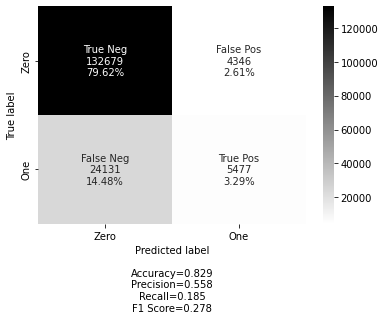

In [482]:
FlorestasAleatorias(2)

## Tentativa 3, com seleção de período mais específico


Quantidade de registros no arquivo: 163820

As colunas no dataframe são: 

Index(['Genero_Masculino', 'Asma', 'Diabetes', 'Cardiopatia',
       'Doenca Hematologica', 'Doenca Hepatica', 'Doenca Neurologica',
       'Doenca Renal', 'Imunodepressao', 'Obesidade', 'Pneumopatia',
       'Puérpera', 'Síndrome de Down', 'Outros Fatores De Risco',
       'Comorbidade', 'Obito', 'até 22 anos', 'de 23 a 29 anos',
       'de 30 a 39 anos', 'de 40 a 49 anos', 'de 50 a 59 anos',
       'de 60 a 69 anos', 'de 70 a 79 anos'],
      dtype='object')

número de amostras para treino:  114674
número de amostras para teste:  49146

Relatório de Classificação:

              precision    recall  f1-score   support

           0       0.88      0.98      0.93     42460
           1       0.54      0.19      0.28      6686

    accuracy                           0.87     49146
   macro avg       0.71      0.58      0.60     49146
weighted avg       0.84      0.87      0.84     49146


Matriz de Confusão do 

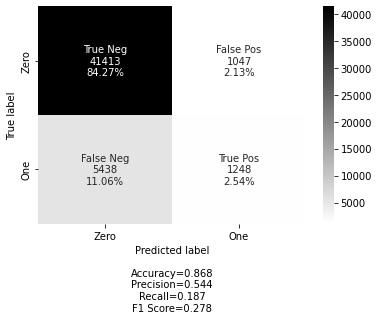

In [483]:
FlorestasAleatorias(3)

## Tentativa 4, quantidade de comorbidades 


Quantidade de registros no arquivo: 163820

As colunas no dataframe são: 

Index(['Genero_Masculino', 'Asma', 'Diabetes', 'Cardiopatia',
       'Doenca Hematologica', 'Doenca Hepatica', 'Doenca Neurologica',
       'Doenca Renal', 'Imunodepressao', 'Obesidade', 'Pneumopatia',
       'Puérpera', 'Síndrome de Down', 'Outros Fatores De Risco', 'Obito',
       'até 22 anos', 'de 23 a 29 anos', 'de 30 a 39 anos', 'de 40 a 49 anos',
       'de 50 a 59 anos', 'de 60 a 69 anos', 'de 70 a 79 anos',
       '2_comorbidades', '3_comorbidades', '4_ou_mais'],
      dtype='object')

número de amostras para treino:  114674
número de amostras para teste:  49146

Relatório de Classificação:

              precision    recall  f1-score   support

           0       0.88      0.98      0.93     42460
           1       0.54      0.19      0.28      6686

    accuracy                           0.87     49146
   macro avg       0.71      0.58      0.60     49146
weighted avg       0.84      0.87      0.84 

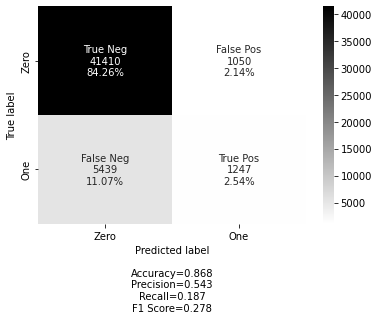

In [484]:
FlorestasAleatorias(4)

## Tentativa 5, com balanceamento - undersampling


Quantidade de registros no arquivo: 163820

As colunas no dataframe são: 

Index(['Genero_Masculino', 'Asma', 'Diabetes', 'Cardiopatia',
       'Doenca Hematologica', 'Doenca Hepatica', 'Doenca Neurologica',
       'Doenca Renal', 'Imunodepressao', 'Obesidade', 'Pneumopatia',
       'Puérpera', 'Síndrome de Down', 'Outros Fatores De Risco',
       'até 22 anos', 'de 23 a 29 anos', 'de 30 a 39 anos', 'de 40 a 49 anos',
       'de 50 a 59 anos', 'de 60 a 69 anos', 'de 70 a 79 anos',
       '2_comorbidades', '3_comorbidades', '4_ou_mais'],
      dtype='object')

número de amostras para treino:  31456
número de amostras para teste:  132364

Relatório de Classificação:

              precision    recall  f1-score   support

           0       0.98      0.72      0.83    125622
           1       0.13      0.80      0.22      6742

    accuracy                           0.72    132364
   macro avg       0.56      0.76      0.53    132364
weighted avg       0.94      0.72      0.80    132364

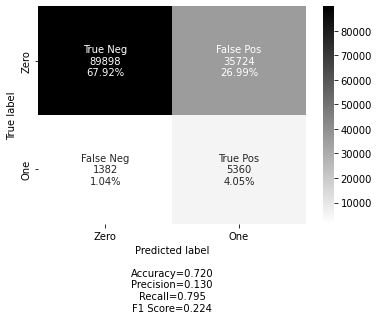

In [485]:
FlorestasAleatorias(5)

## Tentativa 6, com balanceamento dos dados - oversampling SMOTE


Quantidade de registros no arquivo: 163820

As colunas no dataframe são: 

Index(['Genero_Masculino', 'Asma', 'Diabetes', 'Cardiopatia',
       'Doenca Hematologica', 'Doenca Hepatica', 'Doenca Neurologica',
       'Doenca Renal', 'Imunodepressao', 'Obesidade', 'Pneumopatia',
       'Puérpera', 'Síndrome de Down', 'Outros Fatores De Risco', 'Obito',
       'até 22 anos', 'de 23 a 29 anos', 'de 30 a 39 anos', 'de 40 a 49 anos',
       'de 50 a 59 anos', 'de 60 a 69 anos', 'de 70 a 79 anos',
       '2_comorbidades', '3_comorbidades', '4_ou_mais'],
      dtype='object')

Quantidades de recuperados e óbitos na amostra para treino antes do smote:
0    98890
1    15784
Name: Obito, dtype: int64

Quantidades de recuperados e óbitos na amostra para treino depois do smote:
0    98890
1    98890
Name: Obito, dtype: int64

número de amostras para treino:  197780
número de amostras para teste:  49146

Relatório de Classificação:

              precision    recall  f1-score   support

           0

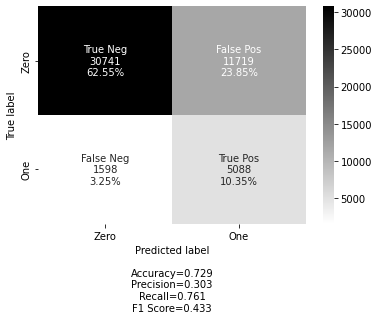

In [486]:
FlorestasAleatorias(6)

# Classificação Bayesiana 

In [487]:
def ClassificacaoBayesiana(num_tentativa):
    global X_train, X_test, y_train, y_test
    arquivo = ""
    if num_tentativa == 1:
        arquivo = 'dados_dummies_1.csv'
    elif num_tentativa == 2:
        arquivo = 'dados_dummies_2.csv'
    elif num_tentativa == 3:
        arquivo = 'dados_dummies_3.csv'
    elif num_tentativa in [4, 6]:
        arquivo = 'dados_dummies_4.csv'
    elif num_tentativa == 5:
        X_train = (pd.read_csv('dados_dummies_5_train.csv', sep = ';')).drop('Obito', axis=1)
        X_test  = (pd.read_csv('dados_dummies_5_test.csv', sep = ';')).drop('Obito', axis=1)
        y_train = pd.read_csv('dados_dummies_5_train.csv', sep = ';')['Obito']
        y_test  = pd.read_csv('dados_dummies_5_test.csv', sep = ';')['Obito']

        print('\nQuantidade de registros no arquivo: {}'.format(len(X_train) + len(X_test)))
    
        print('\nAs colunas no dataframe são: \n')
        print(X_train.columns)
        
    if num_tentativa != 5:    
        df = pd.read_csv(arquivo, sep = ';')

        print('\nQuantidade de registros no arquivo: {}'.format(len(df)))

        print('\nAs colunas no dataframe são: \n')
        print(df.columns)

        X = df.drop('Obito', axis = 1)
        y = df['Obito']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)
        
        if num_tentativa == 6:
            print('\nQuantidades de recuperados e óbitos na amostra para treino antes do smote:')
            print(y_train.to_frame().Obito.value_counts())

            sm = SMOTE(random_state=42) # oversampling SMOTE
            X_train, y_train = sm.fit_resample(X_train, y_train)

            print('\nQuantidades de recuperados e óbitos na amostra para treino depois do smote:')
            print(y_train.to_frame().Obito.value_counts())

    print("\nnúmero de amostras para treino: ", len(X_train))
    print("número de amostras para teste: ", len(y_test))
    
    cnb = CategoricalNB()
    
    y_pred = cnb.fit(X_train, y_train).predict(X_test)
    
    print('\nNúmero de erros de classificação ou "score": ')
    print("{0} de {1}".format((y_test != y_pred).sum(), len(y_test)))
    
    print('\nRelatório de Classificação:\n')
    print(classification_report(y_test, y_pred))
    
    print('\nMatriz de Confusão do Modelo:\n')
    print(confusion_matrix(y_test, y_pred))
    cf_matrix = confusion_matrix(y_test, y_pred)
    make_confusion_matrix(cf_matrix)

## Tentativa 1


Quantidade de registros no arquivo: 555441

As colunas no dataframe são: 

Index(['Genero_Masculino', 'Asma', 'Diabetes', 'Cardiopatia',
       'Doenca Hematologica', 'Doenca Hepatica', 'Doenca Neurologica',
       'Doenca Renal', 'Imunodepressao', 'Obesidade', 'Pneumopatia',
       'Puérpera', 'Síndrome de Down', 'Outros Fatores De Risco',
       'Comorbidade', 'idade_avancada', 'Obito'],
      dtype='object')

número de amostras para treino:  388808
número de amostras para teste:  166633

Número de erros de classificação ou "score": 
28987 de 166633

Relatório de Classificação:

              precision    recall  f1-score   support

           0       0.84      0.97      0.90    137025
           1       0.53      0.16      0.25     29608

    accuracy                           0.83    166633
   macro avg       0.69      0.57      0.58    166633
weighted avg       0.79      0.83      0.79    166633


Matriz de Confusão do Modelo:

[[132833   4192]
 [ 24795   4813]]


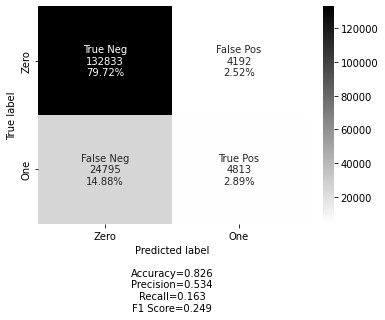

In [488]:
ClassificacaoBayesiana(1)

## Tentativa 2, com faixas etárias 


Quantidade de registros no arquivo: 555441

As colunas no dataframe são: 

Index(['Genero_Masculino', 'Asma', 'Diabetes', 'Cardiopatia',
       'Doenca Hematologica', 'Doenca Hepatica', 'Doenca Neurologica',
       'Doenca Renal', 'Imunodepressao', 'Obesidade', 'Pneumopatia',
       'Puérpera', 'Síndrome de Down', 'Outros Fatores De Risco',
       'Comorbidade', 'Obito', 'até 22 anos', 'de 23 a 29 anos',
       'de 30 a 39 anos', 'de 40 a 49 anos', 'de 50 a 59 anos',
       'de 60 a 69 anos', 'de 70 a 79 anos'],
      dtype='object')

número de amostras para treino:  388808
número de amostras para teste:  166633

Número de erros de classificação ou "score": 
29123 de 166633

Relatório de Classificação:

              precision    recall  f1-score   support

           0       0.85      0.96      0.90    137025
           1       0.52      0.19      0.28     29608

    accuracy                           0.83    166633
   macro avg       0.68      0.58      0.59    166633
weighted avg  

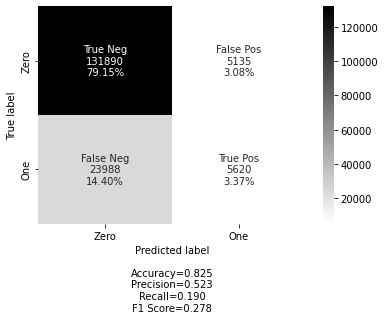

In [489]:
ClassificacaoBayesiana(2)

## tentativa 3, com seleção de período mais específico


Quantidade de registros no arquivo: 163820

As colunas no dataframe são: 

Index(['Genero_Masculino', 'Asma', 'Diabetes', 'Cardiopatia',
       'Doenca Hematologica', 'Doenca Hepatica', 'Doenca Neurologica',
       'Doenca Renal', 'Imunodepressao', 'Obesidade', 'Pneumopatia',
       'Puérpera', 'Síndrome de Down', 'Outros Fatores De Risco',
       'Comorbidade', 'Obito', 'até 22 anos', 'de 23 a 29 anos',
       'de 30 a 39 anos', 'de 40 a 49 anos', 'de 50 a 59 anos',
       'de 60 a 69 anos', 'de 70 a 79 anos'],
      dtype='object')

número de amostras para treino:  114674
número de amostras para teste:  49146

Número de erros de classificação ou "score": 
6838 de 49146

Relatório de Classificação:

              precision    recall  f1-score   support

           0       0.89      0.96      0.92     42460
           1       0.48      0.24      0.32      6686

    accuracy                           0.86     49146
   macro avg       0.68      0.60      0.62     49146
weighted avg     

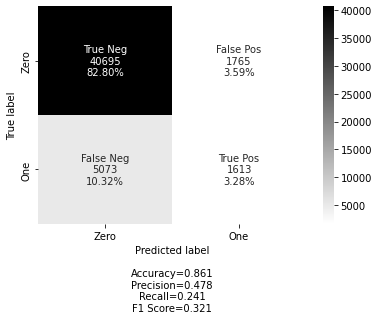

In [490]:
ClassificacaoBayesiana(3)

## Tentativa 4, quantidade de comorbidades


Quantidade de registros no arquivo: 163820

As colunas no dataframe são: 

Index(['Genero_Masculino', 'Asma', 'Diabetes', 'Cardiopatia',
       'Doenca Hematologica', 'Doenca Hepatica', 'Doenca Neurologica',
       'Doenca Renal', 'Imunodepressao', 'Obesidade', 'Pneumopatia',
       'Puérpera', 'Síndrome de Down', 'Outros Fatores De Risco', 'Obito',
       'até 22 anos', 'de 23 a 29 anos', 'de 30 a 39 anos', 'de 40 a 49 anos',
       'de 50 a 59 anos', 'de 60 a 69 anos', 'de 70 a 79 anos',
       '2_comorbidades', '3_comorbidades', '4_ou_mais'],
      dtype='object')

número de amostras para treino:  114674
número de amostras para teste:  49146

Número de erros de classificação ou "score": 
7068 de 49146

Relatório de Classificação:

              precision    recall  f1-score   support

           0       0.90      0.94      0.92     42460
           1       0.46      0.32      0.38      6686

    accuracy                           0.86     49146
   macro avg       0.68      0.63    

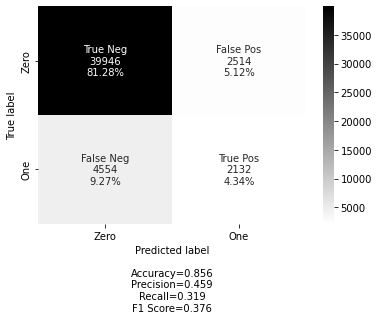

In [491]:
ClassificacaoBayesiana(4)

## Tentativa 5, com balanceamento dos dados - undersampling


Quantidade de registros no arquivo: 163820

As colunas no dataframe são: 

Index(['Genero_Masculino', 'Asma', 'Diabetes', 'Cardiopatia',
       'Doenca Hematologica', 'Doenca Hepatica', 'Doenca Neurologica',
       'Doenca Renal', 'Imunodepressao', 'Obesidade', 'Pneumopatia',
       'Puérpera', 'Síndrome de Down', 'Outros Fatores De Risco',
       'até 22 anos', 'de 23 a 29 anos', 'de 30 a 39 anos', 'de 40 a 49 anos',
       'de 50 a 59 anos', 'de 60 a 69 anos', 'de 70 a 79 anos',
       '2_comorbidades', '3_comorbidades', '4_ou_mais'],
      dtype='object')

número de amostras para treino:  31456
número de amostras para teste:  132364

Número de erros de classificação ou "score": 
32444 de 132364

Relatório de Classificação:

              precision    recall  f1-score   support

           0       0.98      0.76      0.85    125622
           1       0.13      0.69      0.22      6742

    accuracy                           0.75    132364
   macro avg       0.56      0.72      0.54 

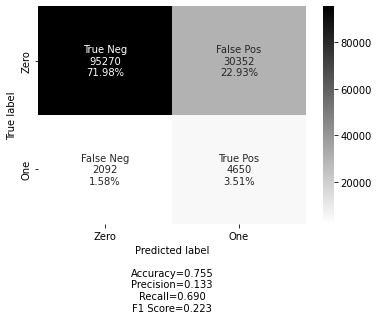

In [492]:
ClassificacaoBayesiana(5)

## Tentativa 6, com balanceamento dos dados - oversampling SMOTE


Quantidade de registros no arquivo: 163820

As colunas no dataframe são: 

Index(['Genero_Masculino', 'Asma', 'Diabetes', 'Cardiopatia',
       'Doenca Hematologica', 'Doenca Hepatica', 'Doenca Neurologica',
       'Doenca Renal', 'Imunodepressao', 'Obesidade', 'Pneumopatia',
       'Puérpera', 'Síndrome de Down', 'Outros Fatores De Risco', 'Obito',
       'até 22 anos', 'de 23 a 29 anos', 'de 30 a 39 anos', 'de 40 a 49 anos',
       'de 50 a 59 anos', 'de 60 a 69 anos', 'de 70 a 79 anos',
       '2_comorbidades', '3_comorbidades', '4_ou_mais'],
      dtype='object')

Quantidades de recuperados e óbitos na amostra para treino antes do smote:
0    98890
1    15784
Name: Obito, dtype: int64

Quantidades de recuperados e óbitos na amostra para treino depois do smote:
0    98890
1    98890
Name: Obito, dtype: int64

número de amostras para treino:  197780
número de amostras para teste:  49146

Número de erros de classificação ou "score": 
12147 de 49146

Relatório de Classificação:

     

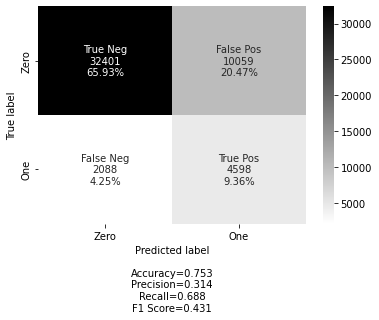

In [493]:
ClassificacaoBayesiana(6)